In [3]:
! pip install python_speech_features

In [1]:
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional,Flatten, GRU
from keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, Bidirectional
from keras.layers import Conv1D, BatchNormalization, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dropout
from python_speech_features import mfcc
from python_speech_features import logfbank
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder,normalize
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import scipy.io.wavfile as wav
import numpy as np
import keras
import csv
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import librosa
import soundfile as sf
import pickle

In [10]:
! cp /kaggle/input/tensorflow-speech-recognition-challenge/train.7z ./
! 7za x train.7z

'cp' is not recognized as an internal or external command,
operable program or batch file.



7-Zip (A) 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18

Processing archive: train.7z

Extracting  train
Extracting  train\audio
Extracting  train\audio\_background_noise_
Extracting  train\audio\bed
Extracting  train\audio\bird
Extracting  train\audio\cat
Extracting  train\audio\dog
Extracting  train\audio\down
Extracting  train\audio\eight
Extracting  train\audio\five
Extracting  train\audio\four
Extracting  train\audio\go
Extracting  train\audio\happy
Extracting  train\audio\house
Extracting  train\audio\left
Extracting  train\audio\marvin
Extracting  train\audio\nine
Extracting  train\audio\no
Extracting  train\audio\off
Extracting  train\audio\on
Extracting  train\audio\one
Extracting  train\audio\right
Extracting  train\audio\seven
Extracting  train\audio\sheila
Extracting  train\audio\six
Extracting  train\audio\stop
Extracting  train\audio\three
Extracting  train\audio\tree
Extracting  train\audio\two
Extracting  train\audio\up
Extracting  train\audio\wow
Extracting  t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
def convert_background_noise(root_path='./train', input_folder='_background_noise_', output_folder='silence'):
    audio_path = os.path.join(root_path, 'audio')
    input_path = os.path.join(audio_path, input_folder)
    output_path = os.path.join(audio_path, output_folder)
    
    sample_rate = 16000
    sample_length = 1

    audio_files = [d for d in os.listdir(input_path)
                   if os.path.isfile(os.path.join(input_path, d)) and d.endswith('.wav')]
    samples = []

    for f in audio_files:
        path = os.path.join(input_path, f)
        s, _ = librosa.load(path, sr=sample_rate)
        samples.append(s)

    samples = np.hstack(samples)
    c = int(sample_rate * sample_length)
    r = len(samples) // c
    names = [f'recording_{i}.wav' for i in range(r-1)]

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for i in range(r - 1):
        y = samples[c*i:c*(i+1)]
        sf.write(os.path.join(output_path, names[i]), y, sample_rate)

    val_choice = np.random.choice(names, int(0.1*len(names)), replace=False).tolist()
    with open(os.path.join(root_path, 'validation_list.txt'), 'a') as f:
        for name in val_choice:
            p = os.path.join(output_folder, name)
            p = p.replace('./', '')
            f.write(p)
            f.write('\n')

    test_choice = np.random.choice([n for n in names if n not in val_choice], int(0.1*len(names)), replace=False).tolist()
    with open(os.path.join(root_path, 'testing_list.txt'), 'a') as f:
        for name in test_choice:
            p = os.path.join(output_folder, name)
            p = p.replace('./', '')
            f.write(p)
            f.write('\n')

In [3]:
convert_background_noise(root_path='./train', input_folder='_background_noise_', output_folder='silence')

In [4]:
def load_dataset(root_path_files, files_names_list_name, label_encoder=None):
    #Calculating x_test and y_test        
    test_labels = []
    test_data = []

    #test_labels.txt is a txt file with all labels for the speech samples that is required for the evaluation. We loop through it to calculate the MFCC value for each speech sample and then normalize it
    with open(os.path.join(root_path_files, files_names_list_name), newline='') as tsvfile:
        reader = csv.DictReader(tsvfile)
        reader = csv.reader(tsvfile, delimiter=' ')
        for row in reader:
            wav_file = os.path.join(root_path_files, "audio/", row[0])

            row.append(row[0].split("/")[0])
            (rate,sig) = wav.read(wav_file)

            # pad to 1s of length using pad_sequences
            sig = pad_sequences([sig], maxlen=16000, dtype='float', padding='post', truncating='post', value=0.0)

            #Getting the MFCC value from the .wav files.
            mfcc_feat = mfcc(sig,rate)
            
            scaler = MinMaxScaler(feature_range=(0,1))
            scaler = scaler.fit(mfcc_feat)

            #Normalizing the MFCC values.
            normalized = scaler.transform(mfcc_feat)
            test_data.append(normalized)
            test_labels.append(str(row[1]))
        
        label_encoder = ["bed", "bird", "cat", "dog", "down", "eight", "five", "four", "go", "happy", "house", "left", "marvin", "nine", "no", "off", "on", "one", "right", "seven", "sheila", "silence", "six", "stop", "three", "tree", "two", "up", "wow", "yes", "zero"]
        label_encoder = LabelEncoder().fit(label_encoder)
        
        
        label_encoder_test = label_encoder
        vec_test = label_encoder_test.transform(test_labels)

        #One hot encoding the labels
        one_hot_labels_test = keras.utils.to_categorical(vec_test, num_classes=len(label_encoder_test.classes_))
        Y_test = one_hot_labels_test
        X_test = np.array(test_data,dtype=np.float32)
        return X_test, Y_test, label_encoder_test

In [5]:
def generate_train_txt(root_path_files, files_names_list_name):
    omit = []
    train = []
    for f in files_names_list_name:
        with open(os.path.join(root_path_files, f)) as fileobj:
            omit += [line.strip() for line in fileobj]
    for target in os.listdir(os.path.join(root_path_files, 'audio')):
        if not target.startswith('_'):
            for file in os.listdir(os.path.join(root_path_files, 'audio', target)):
                p = os.path.join(target, file)
                if p not in omit:
                    train.append(p)
    with open(os.path.join(root_path_files, 'training_list.txt'), 'wb') as file:
        for t in train:
            file.write(t.encode())
            file.write('\n'.encode())

In [6]:
root_path_files = './train'
root_saved_files = './preprocessed'

generate_train_txt(root_path_files, ['validation_list.txt', 'testing_list.txt'])

In [8]:
train_files_names_list_name = 'training_list.txt'
X_train, Y_train, label_encoder = load_dataset(root_path_files=root_path_files, files_names_list_name=train_files_names_list_name)
np.save(os.path.join(root_saved_files, 'X_train'), X_train)
np.save(os.path.join(root_saved_files, 'Y_train'), Y_train)

In [9]:
valid_files_names_list_name = 'validation_list.txt'
X_valid, Y_valid, _ = load_dataset(root_path_files=root_path_files, files_names_list_name=valid_files_names_list_name, label_encoder = label_encoder)

In [10]:
np.save(os.path.join(root_saved_files, 'X_valid'), X_valid)
np.save(os.path.join(root_saved_files, 'Y_valid'), Y_valid)

In [11]:
test_files_names_list_name = 'testing_list.txt'
X_test, Y_test, _ = load_dataset(root_path_files=root_path_files, files_names_list_name=test_files_names_list_name, label_encoder = label_encoder)

In [12]:
np.save(os.path.join(root_saved_files, 'X_test'), X_test)
np.save(os.path.join(root_saved_files, 'Y_test'), Y_test)

In [13]:
with open('encoder', 'wb') as f:
    pickle.dump(label_encoder, f)

In [14]:
root_saved_files = './preprocessed'

X_train = np.load(os.path.join(root_saved_files,'X_train.npy'))
Y_train = np.load(os.path.join(root_saved_files, 'Y_train.npy'))

X_test = np.load(os.path.join(root_saved_files, 'X_test.npy'))
Y_test = np.load(os.path.join(root_saved_files, 'Y_test.npy'))

X_valid = np.load(os.path.join(root_saved_files, 'X_valid.npy'))
Y_valid = np.load(os.path.join(root_saved_files, 'Y_valid.npy'))

In [15]:
with open('encoder', 'rb') as f:
    encoder = pickle.load(f)
    CLASSES = encoder.classes_

In [16]:
n_classes = len(CLASSES)
print(n_classes)

31


In [17]:
def update_seed(new_random_seed):
    np.random.seed(new_random_seed)
    tf.keras.utils.set_random_seed(new_random_seed)

In [18]:
def train_model(model, train_data, val_data, test_data, lr, epochs, batch, path='checkpoint'):
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode = 'min')
    ]
    m = model()
    m.compile(optimizer=Adam(amsgrad=True, learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])
    history = m.fit(train_data[0], train_data[1],
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=batch,
                    validation_data=val_data,
                    verbose=1,
                    shuffle=True)

    datetime = time.strftime("%Y%m%d-%H%M%S")
    m.save(os.path.join(path, 'model_' + datetime))

    #plotting the loss
    history = m.history
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history["val_loss"])
    pyplot.title("train and validation loss")
    pyplot.ylabel("value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    #plotting the loss
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history["val_accuracy"])
    pyplot.title("train and validation accuracy")
    pyplot.ylabel("accuracy value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    y_prediction = m.predict(test_data[0])
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test_single_column=np.argmax(test_data[1], axis=1)
    result = confusion_matrix(y_test_single_column, y_prediction , normalize='pred')
    plt.figure(figsize=(20,20))
    labels = CLASSES
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()
    
    result = confusion_matrix(y_test_single_column, y_prediction)
    plt.figure(figsize=(20,20))
    labels = CLASSES
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()

    
    acc_train = accuracy_score(np.argmax(train_data[1], axis=1), np.argmax(m.predict(train_data[0]), axis = 1))
    print(f"Accuracy score on train dataset: {acc_train}")
    acc_val = accuracy_score(np.argmax(val_data[1], axis=1), np.argmax(m.predict(val_data[0]), axis = 1))
    print(f"Accuracy score on validation dataset: {acc_val}")
    acc_test = accuracy_score(y_test_single_column, y_prediction)
    print(f"Accuracy score on test dataset: {acc_test}")

    return [acc_train, acc_val, acc_test]

In [19]:
def repeat_train(model, train_data, val_data, test_data, lr, epochs, batch, seeds, path='checkpoint'):
    accuracy = []
    for seed in seeds:
        print(f"Training with seed {seed}")
        p = os.path.join(path, str(seed))
        if not os.path.exists(path):
            os.mkdir(path)
        if not os.path.exists(p):
            os.mkdir(p)
        update_seed(seed)
        acc = train_model(model, train_data, val_data, test_data, lr, epochs, batch, path=p)
        accuracy.append(acc)
    with open(os.path.join(path, 'accuracy'), 'wb') as f:
        pickle.dump(accuracy, f)

In [20]:
from tensorflow.keras.layers import GRU

Training with seed 0

Epoch 1/25


2031/2031 [==============================] - 207s 101ms/step - loss: 1.6179 - accuracy: 0.5220 - val_loss: 0.8574 - val_accuracy: 0.7478
Epoch 2/25
2031/2031 [==============================] - 375s 185ms/step - loss: 0.5743 - accuracy: 0.8329 - val_loss: 0.4729 - val_accuracy: 0.8659
Epoch 3/25
2031/2031 [==============================] - 374s 184ms/step - loss: 0.3908 - accuracy: 0.8881 - val_loss: 0.3572 - val_accuracy: 0.8995
Epoch 4/25
2031/2031 [==============================] - 375s 185ms/step - loss: 0.3071 - accuracy: 0.9124 - val_loss: 0.2903 - val_accuracy: 0.9183
Epoch 5/25
2031/2031 [==============================] - 375s 185ms/step - loss: 0.2576 - accuracy: 0.9257 - val_loss: 0.2387 - val_accuracy: 0.9307
Epoch 6/25
2031/2031 [==============================] - 375s 185ms/step - loss: 0.2278 - accuracy: 0.9350 - val_loss: 0.2243 - val_accuracy: 0.9345
Epoch 7/25
2031/2031 [==============================] - 375s 184ms/step - loss: 0.1981 -

INFO:tensorflow:Assets written to: checkpoint_lstm_two_layer\0\model_20240119-134314\assets


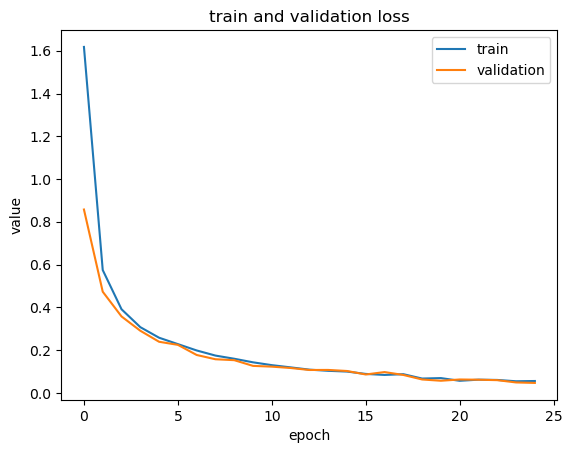

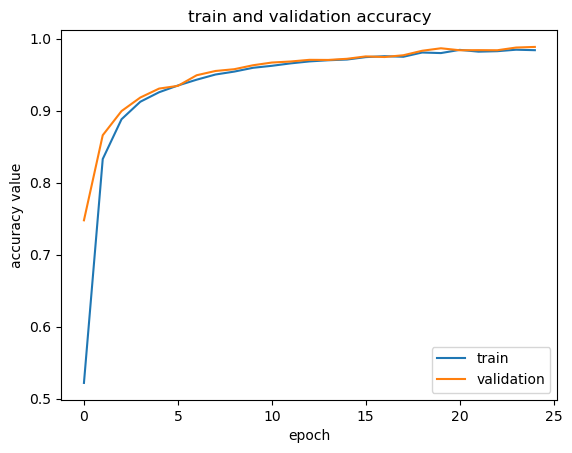

218/218 [==============================] - 7s 29ms/step


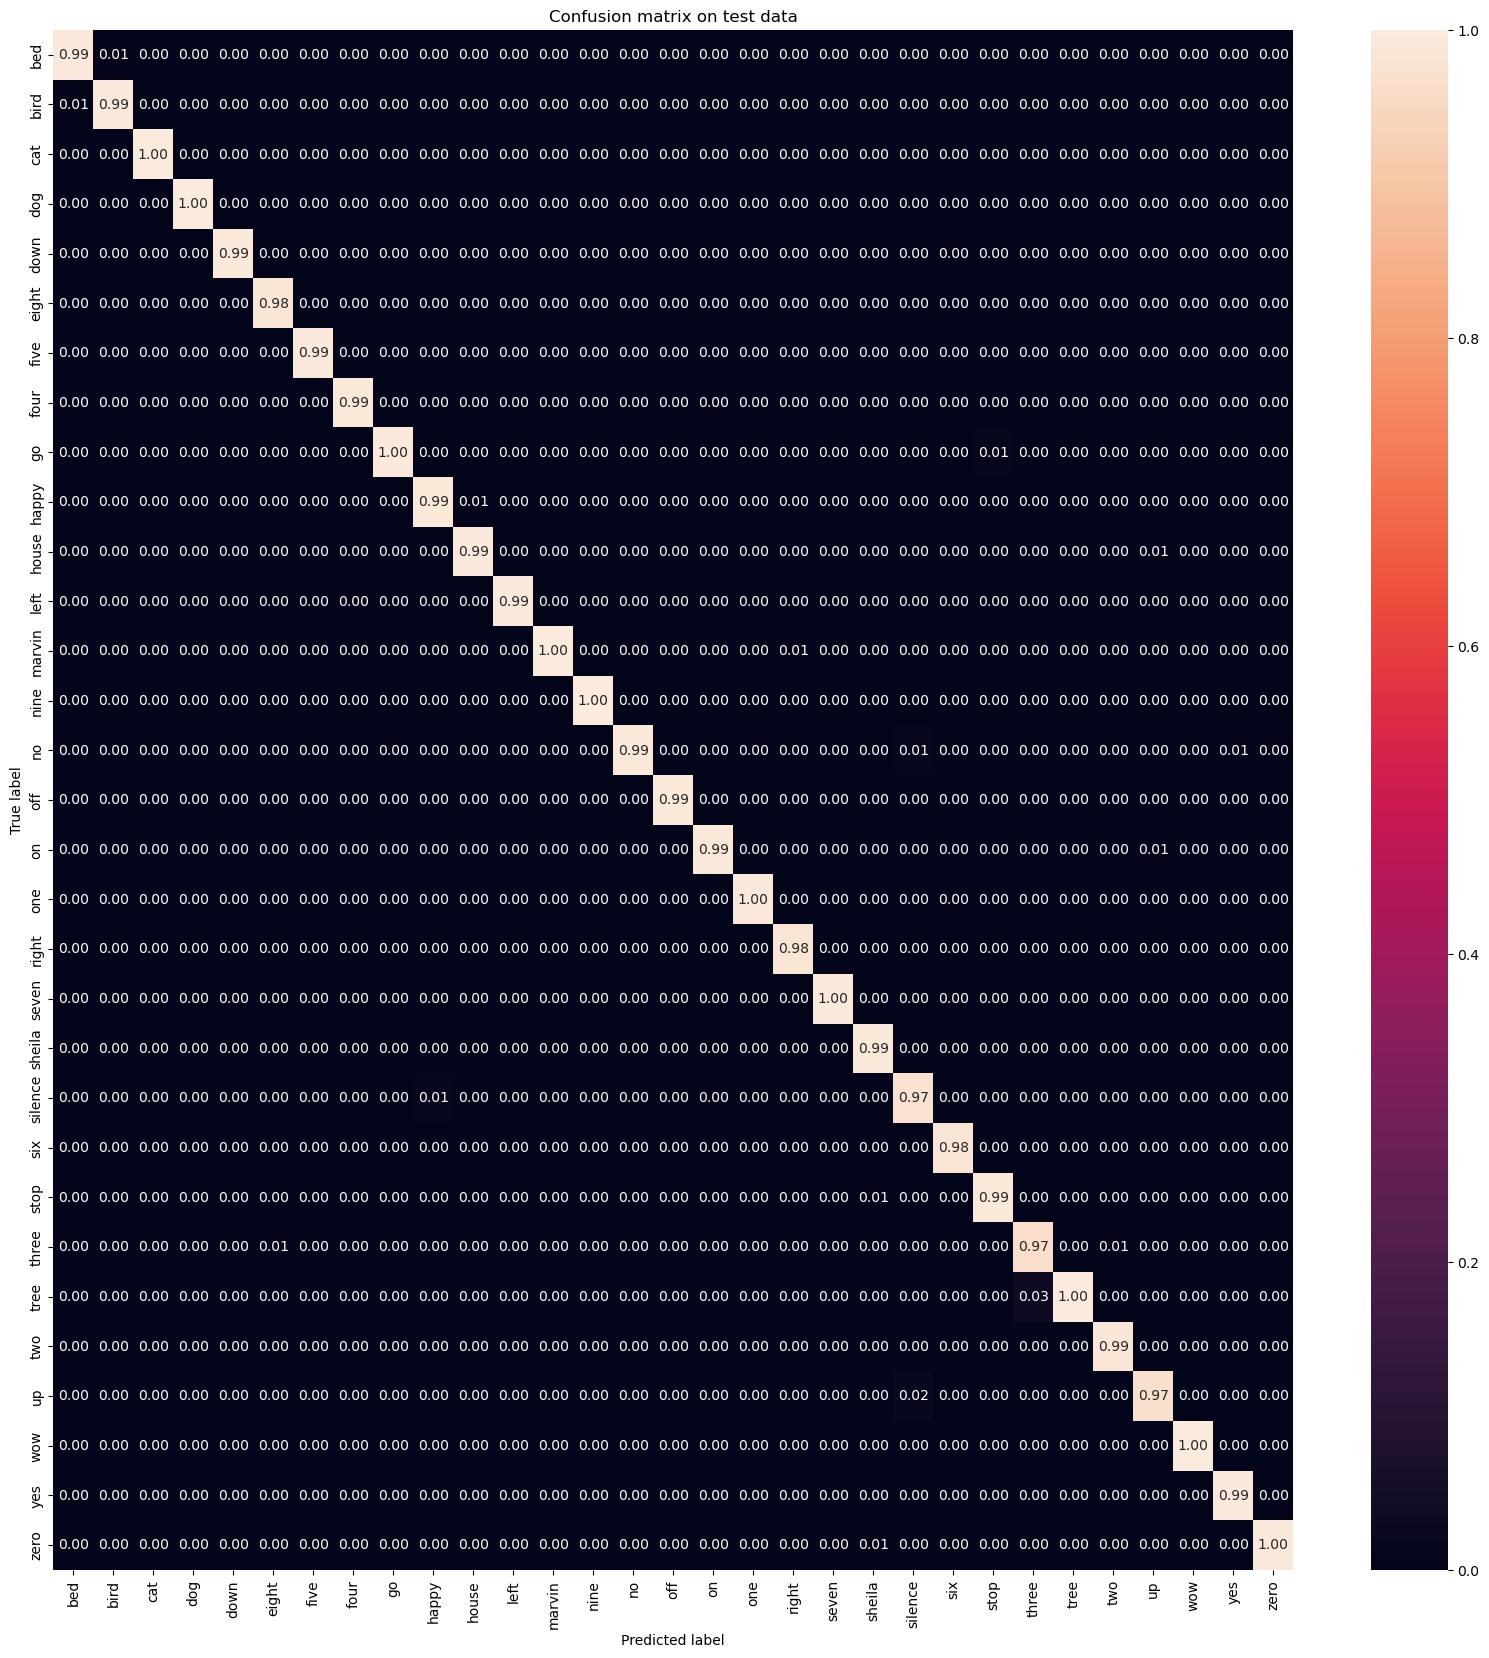

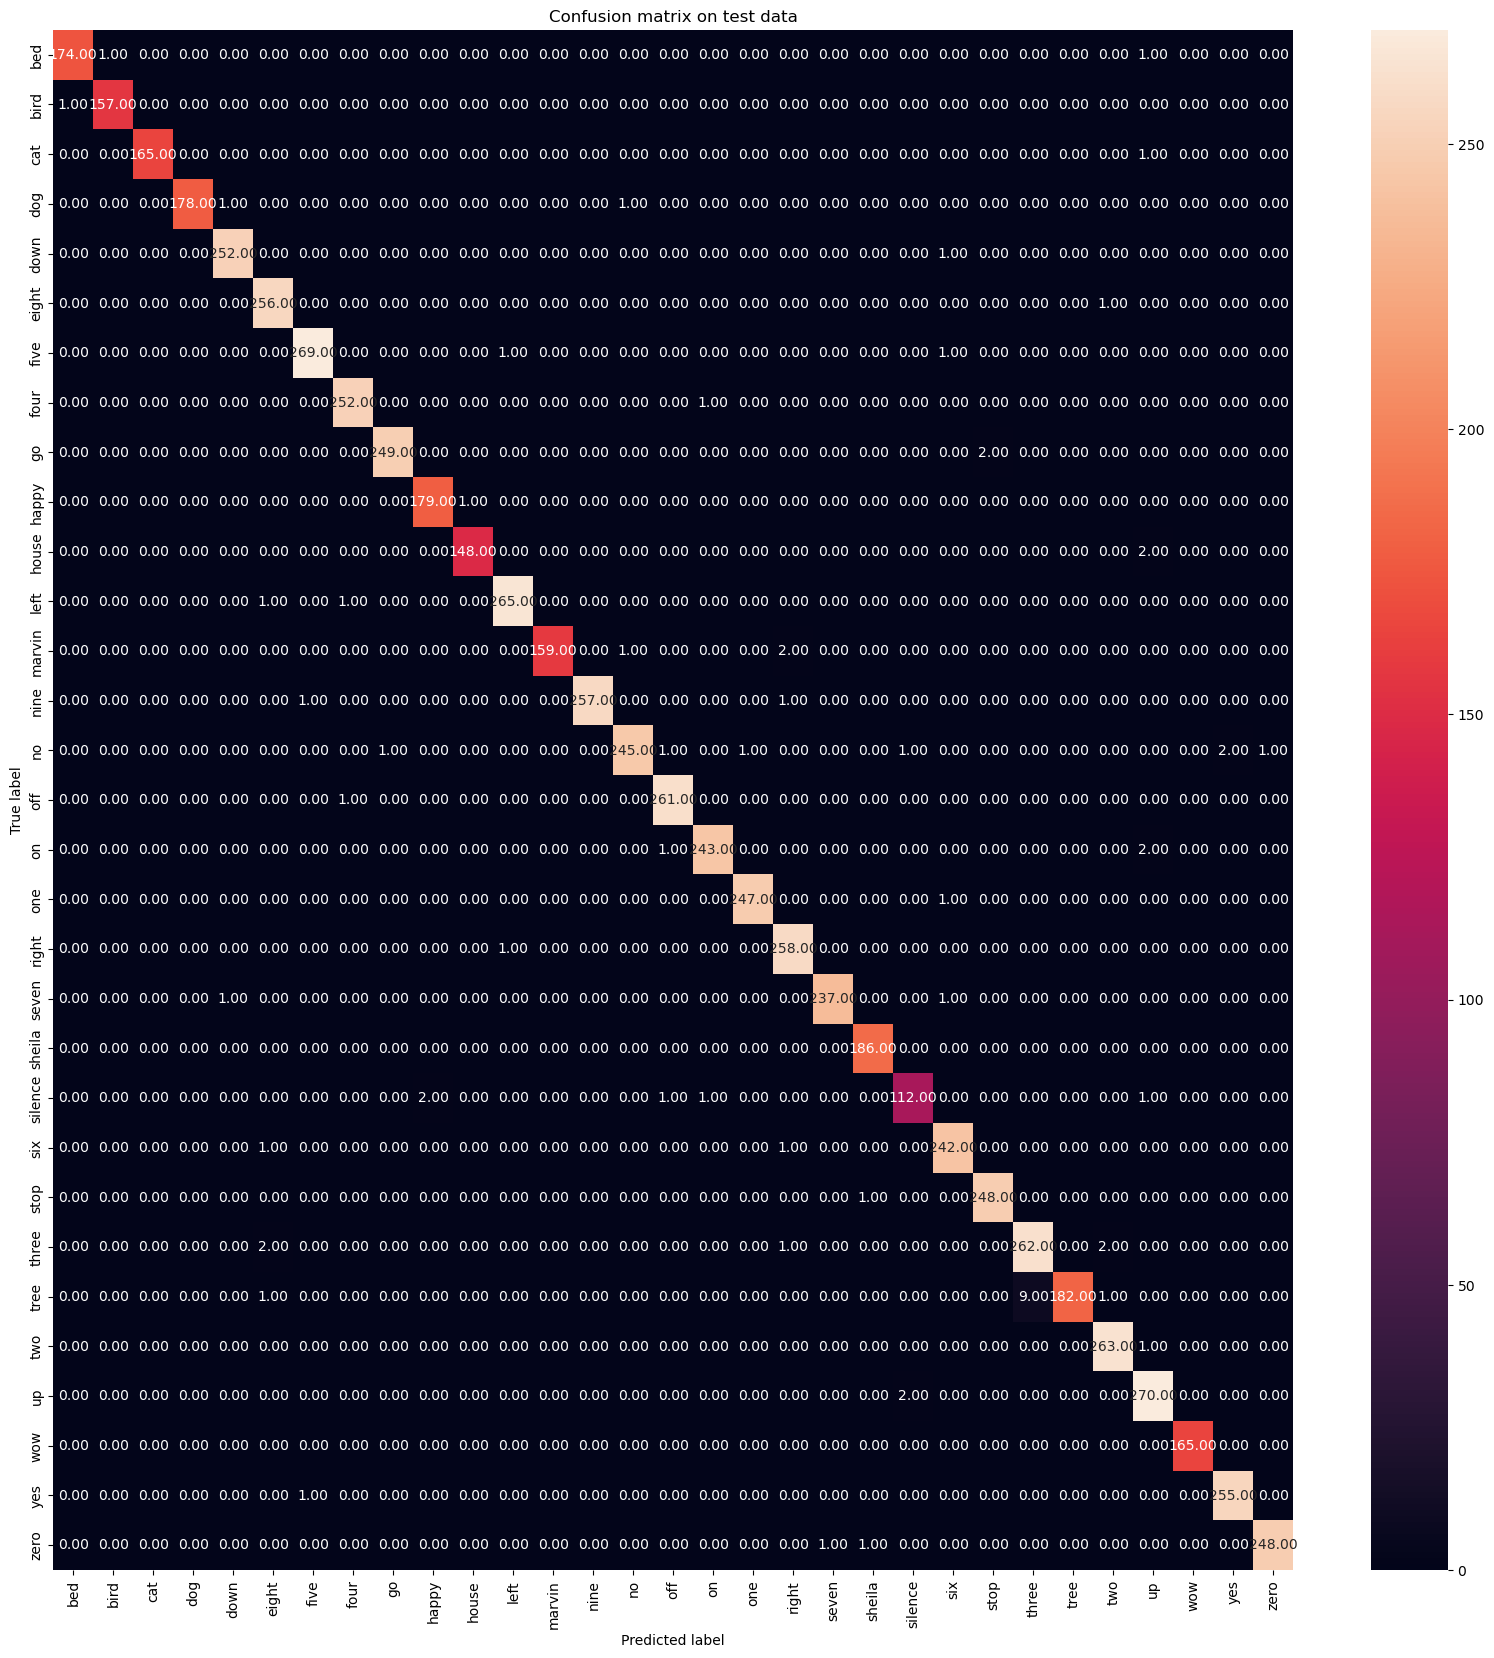

2031/2031 [==============================] - 64s 31ms/step
Accuracy score on train dataset: 0.9911046815845364
217/217 [==============================] - 7s 31ms/step
Accuracy score on validation dataset: 0.9885755603759943
Accuracy score on test dataset: 0.9902186421173763
Training with seed 40
Epoch 1/25
2031/2031 [==============================] - 168s 82ms/step - loss: 1.6986 - accuracy: 0.4992 - val_loss: 0.8333 - val_accuracy: 0.7518
Epoch 2/25
2031/2031 [==============================] - 162s 80ms/step - loss: 0.6286 - accuracy: 0.8173 - val_loss: 0.4380 - val_accuracy: 0.8727
Epoch 3/25
2031/2031 [==============================] - 162s 80ms/step - loss: 0.4112 - accuracy: 0.8833 - val_loss: 0.3332 - val_accuracy: 0.9054
Epoch 4/25
2031/2031 [==============================] - 162s 80ms/step - loss: 0.3132 - accuracy: 0.9110 - val_loss: 0.2907 - val_accuracy: 0.9166
Epoch 5/25
2031/2031 [==============================] - 162s 80ms/step - loss: 0.2586 - accuracy: 0.9264 - val_loss

INFO:tensorflow:Assets written to: checkpoint_lstm_two_layer\40\model_20240119-145217\assets


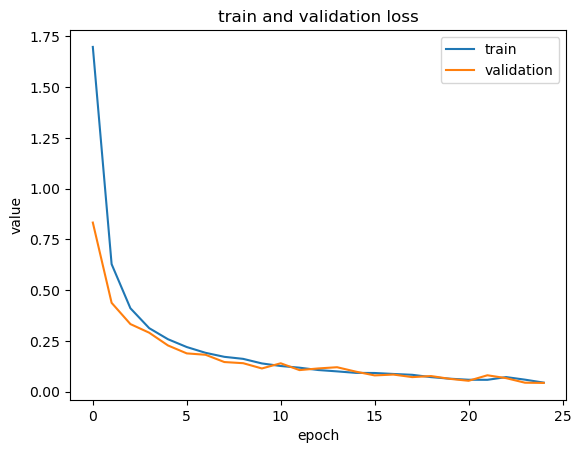

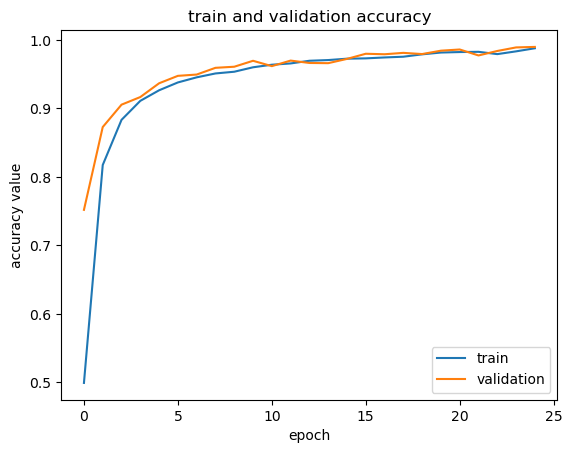

218/218 [==============================] - 7s 30ms/step


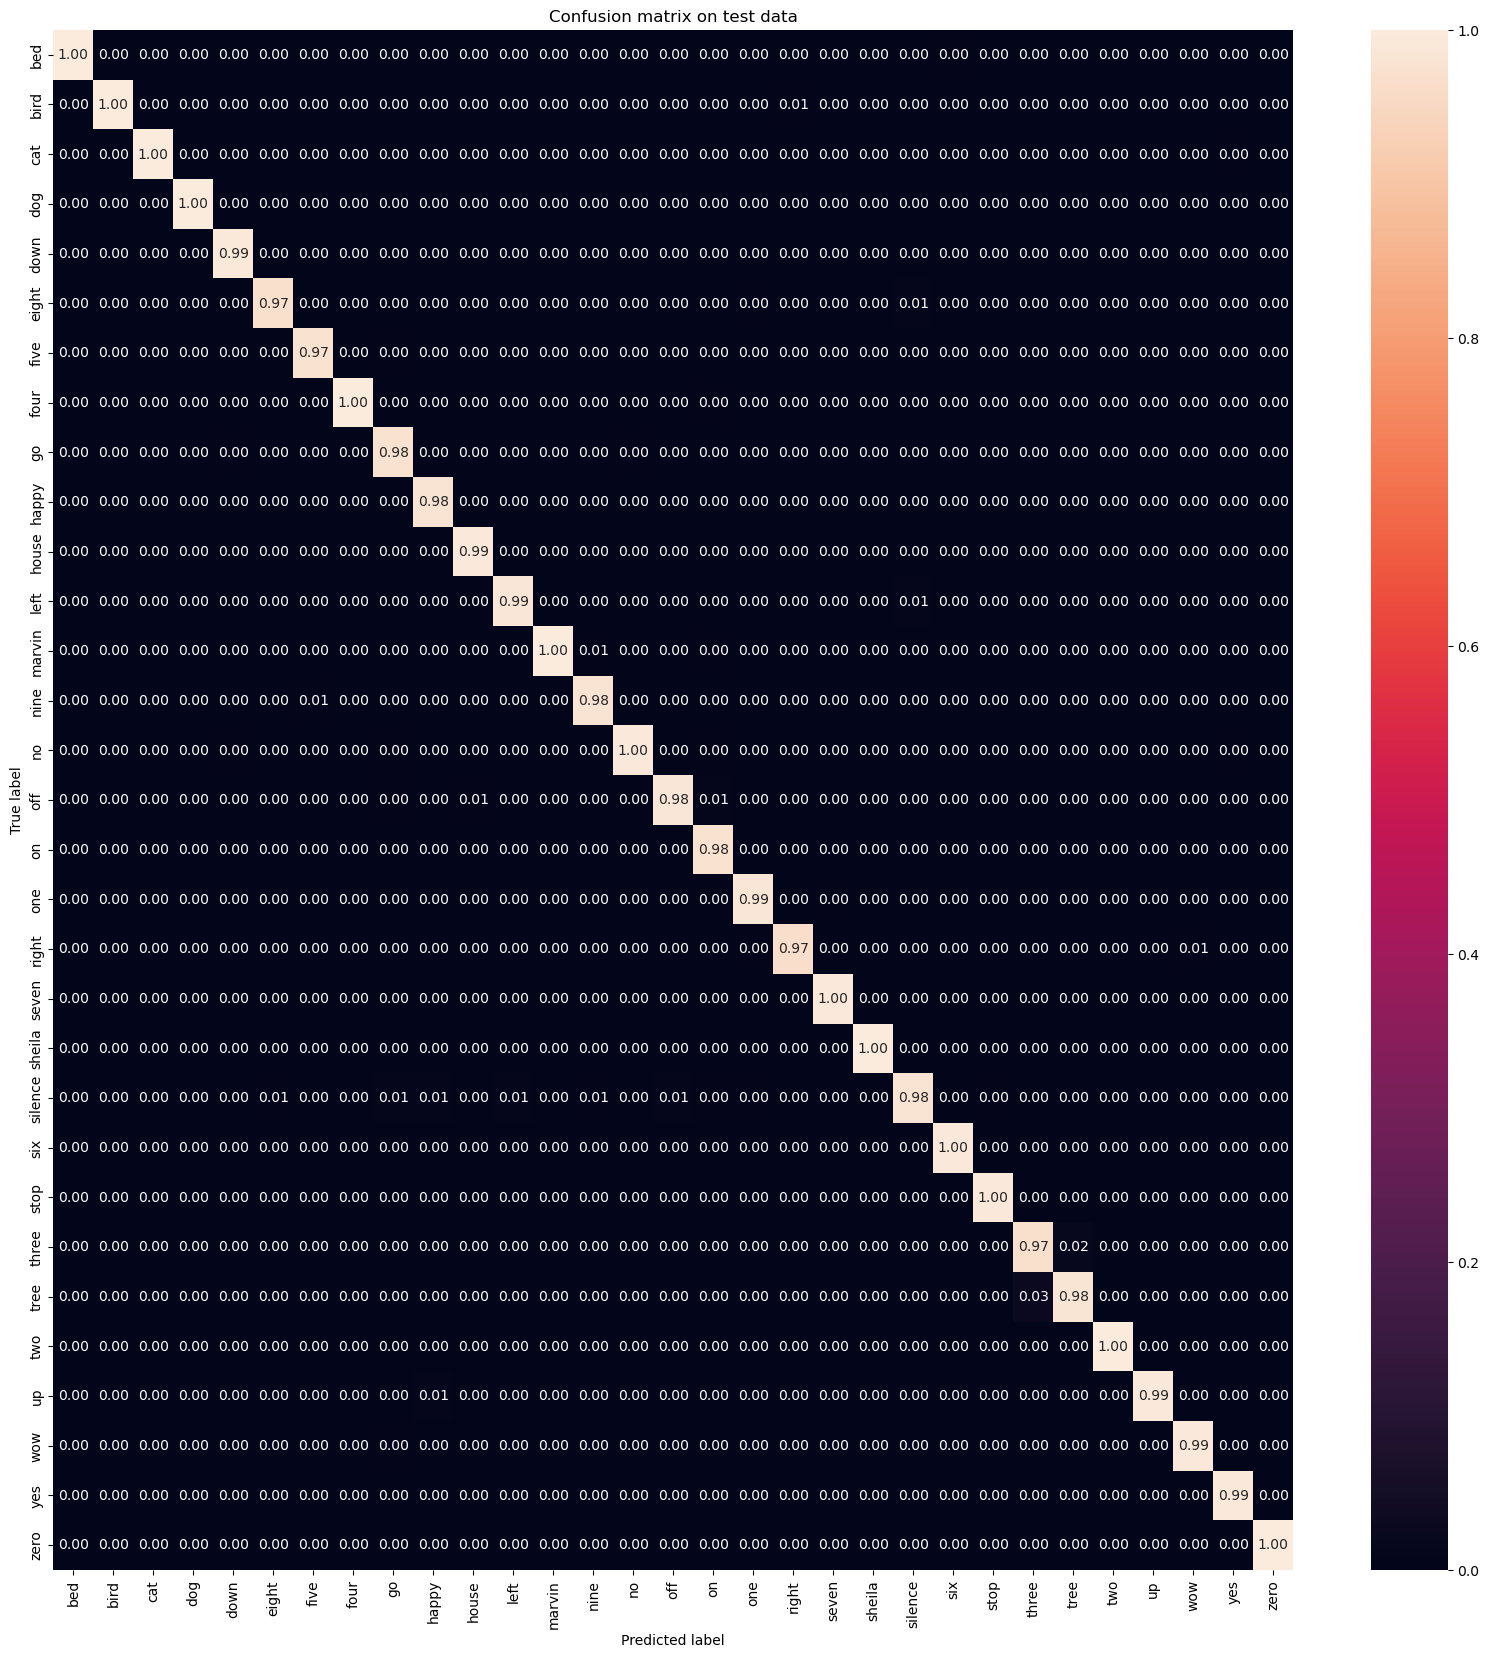

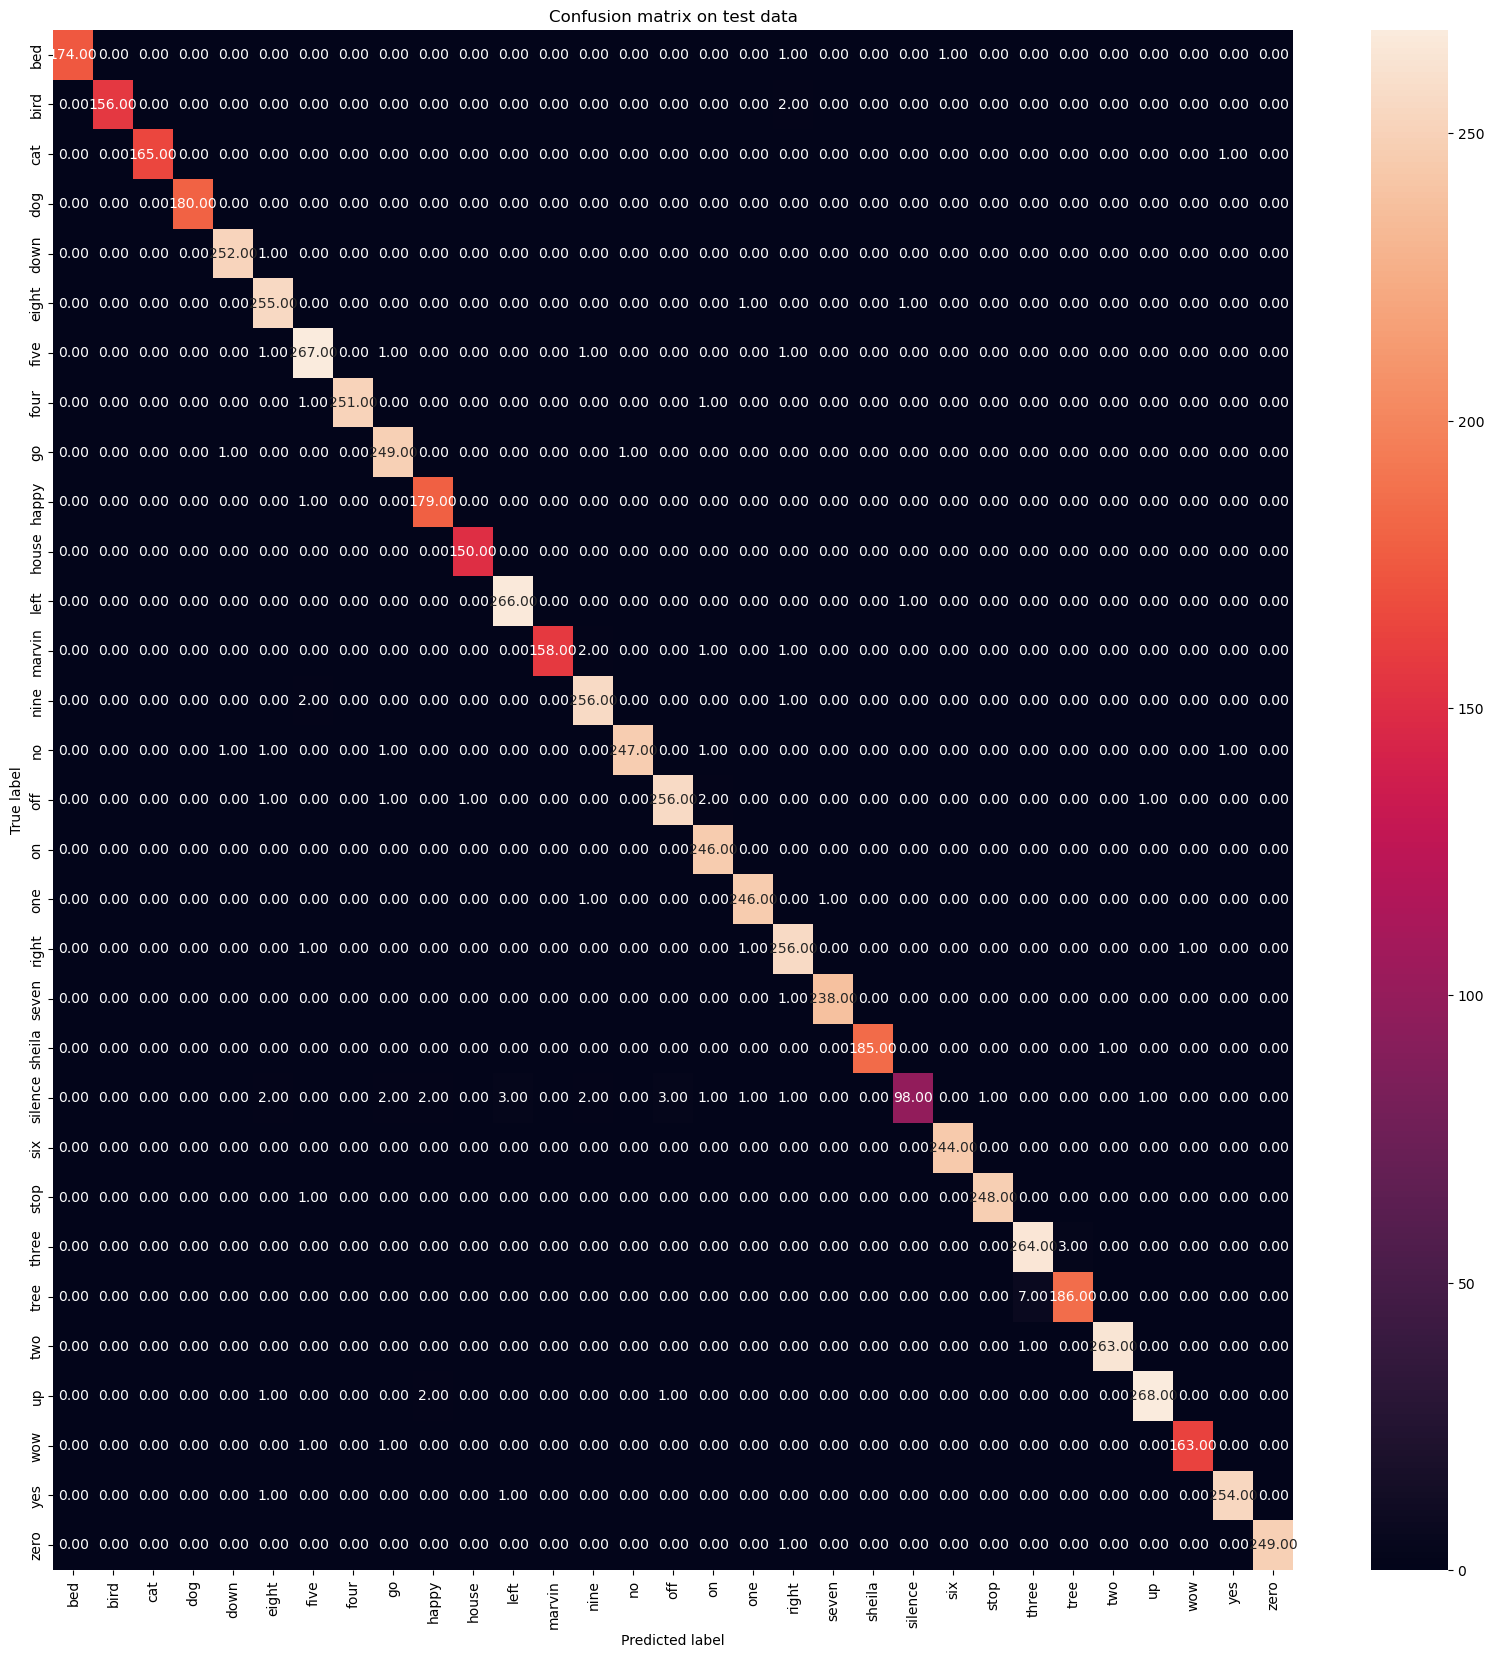

2031/2031 [==============================] - 70s 34ms/step
Accuracy score on train dataset: 0.9919819015666841
217/217 [==============================] - 7s 33ms/step
Accuracy score on validation dataset: 0.9897324656543746
Accuracy score on test dataset: 0.9880609896432682


In [21]:
def model1():
    model = Sequential()
    model.add(LSTM(200,input_shape=(99,13),return_sequences=True))
    model.add(LSTM(200,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

repeat_train(model1, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=25, batch=32,
             seeds=[0, 40], path='checkpoint_lstm_two_layer')

Training with seed 0
Epoch 1/25
2031/2031 [==============================] - 253s 124ms/step - loss: 1.5840 - accuracy: 0.5297 - val_loss: 0.7865 - val_accuracy: 0.7727
Epoch 2/25
2031/2031 [==============================] - 246s 121ms/step - loss: 0.5252 - accuracy: 0.8480 - val_loss: 0.4152 - val_accuracy: 0.8813
Epoch 3/25
2031/2031 [==============================] - 246s 121ms/step - loss: 0.3462 - accuracy: 0.9012 - val_loss: 0.3171 - val_accuracy: 0.9092
Epoch 4/25
2031/2031 [==============================] - 246s 121ms/step - loss: 0.2750 - accuracy: 0.9217 - val_loss: 0.2360 - val_accuracy: 0.9341
Epoch 5/25
2031/2031 [==============================] - 246s 121ms/step - loss: 0.2245 - accuracy: 0.9352 - val_loss: 0.2102 - val_accuracy: 0.9409
Epoch 6/25
2031/2031 [==============================] - 246s 121ms/step - loss: 0.1876 - accuracy: 0.9463 - val_loss: 0.1732 - val_accuracy: 0.9530
Epoch 7/25
2031/2031 [==============================] - 246s 121ms/step - loss: 0.1687 - ac

INFO:tensorflow:Assets written to: checkpoint_lstm_hidden_300\0\model_20240119-163227\assets


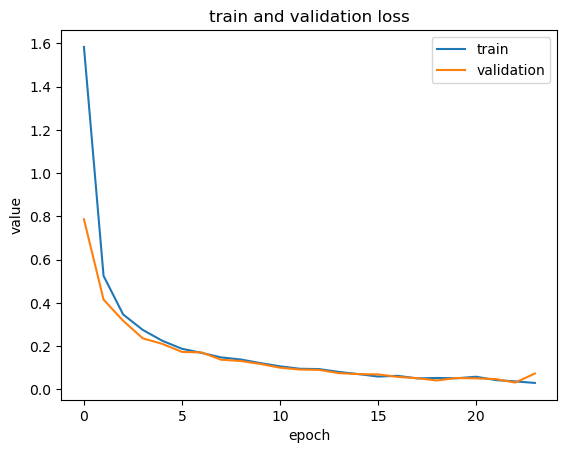

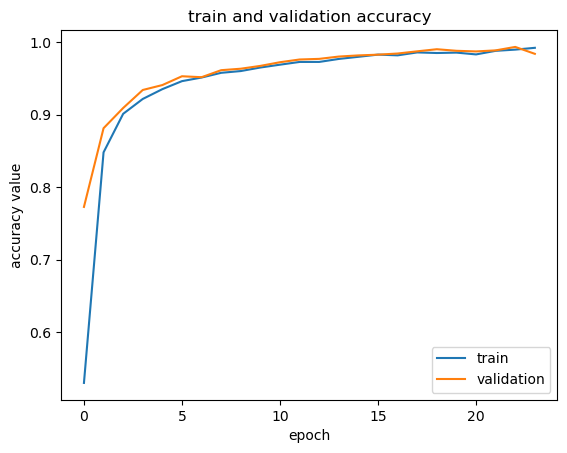

218/218 [==============================] - 9s 40ms/step


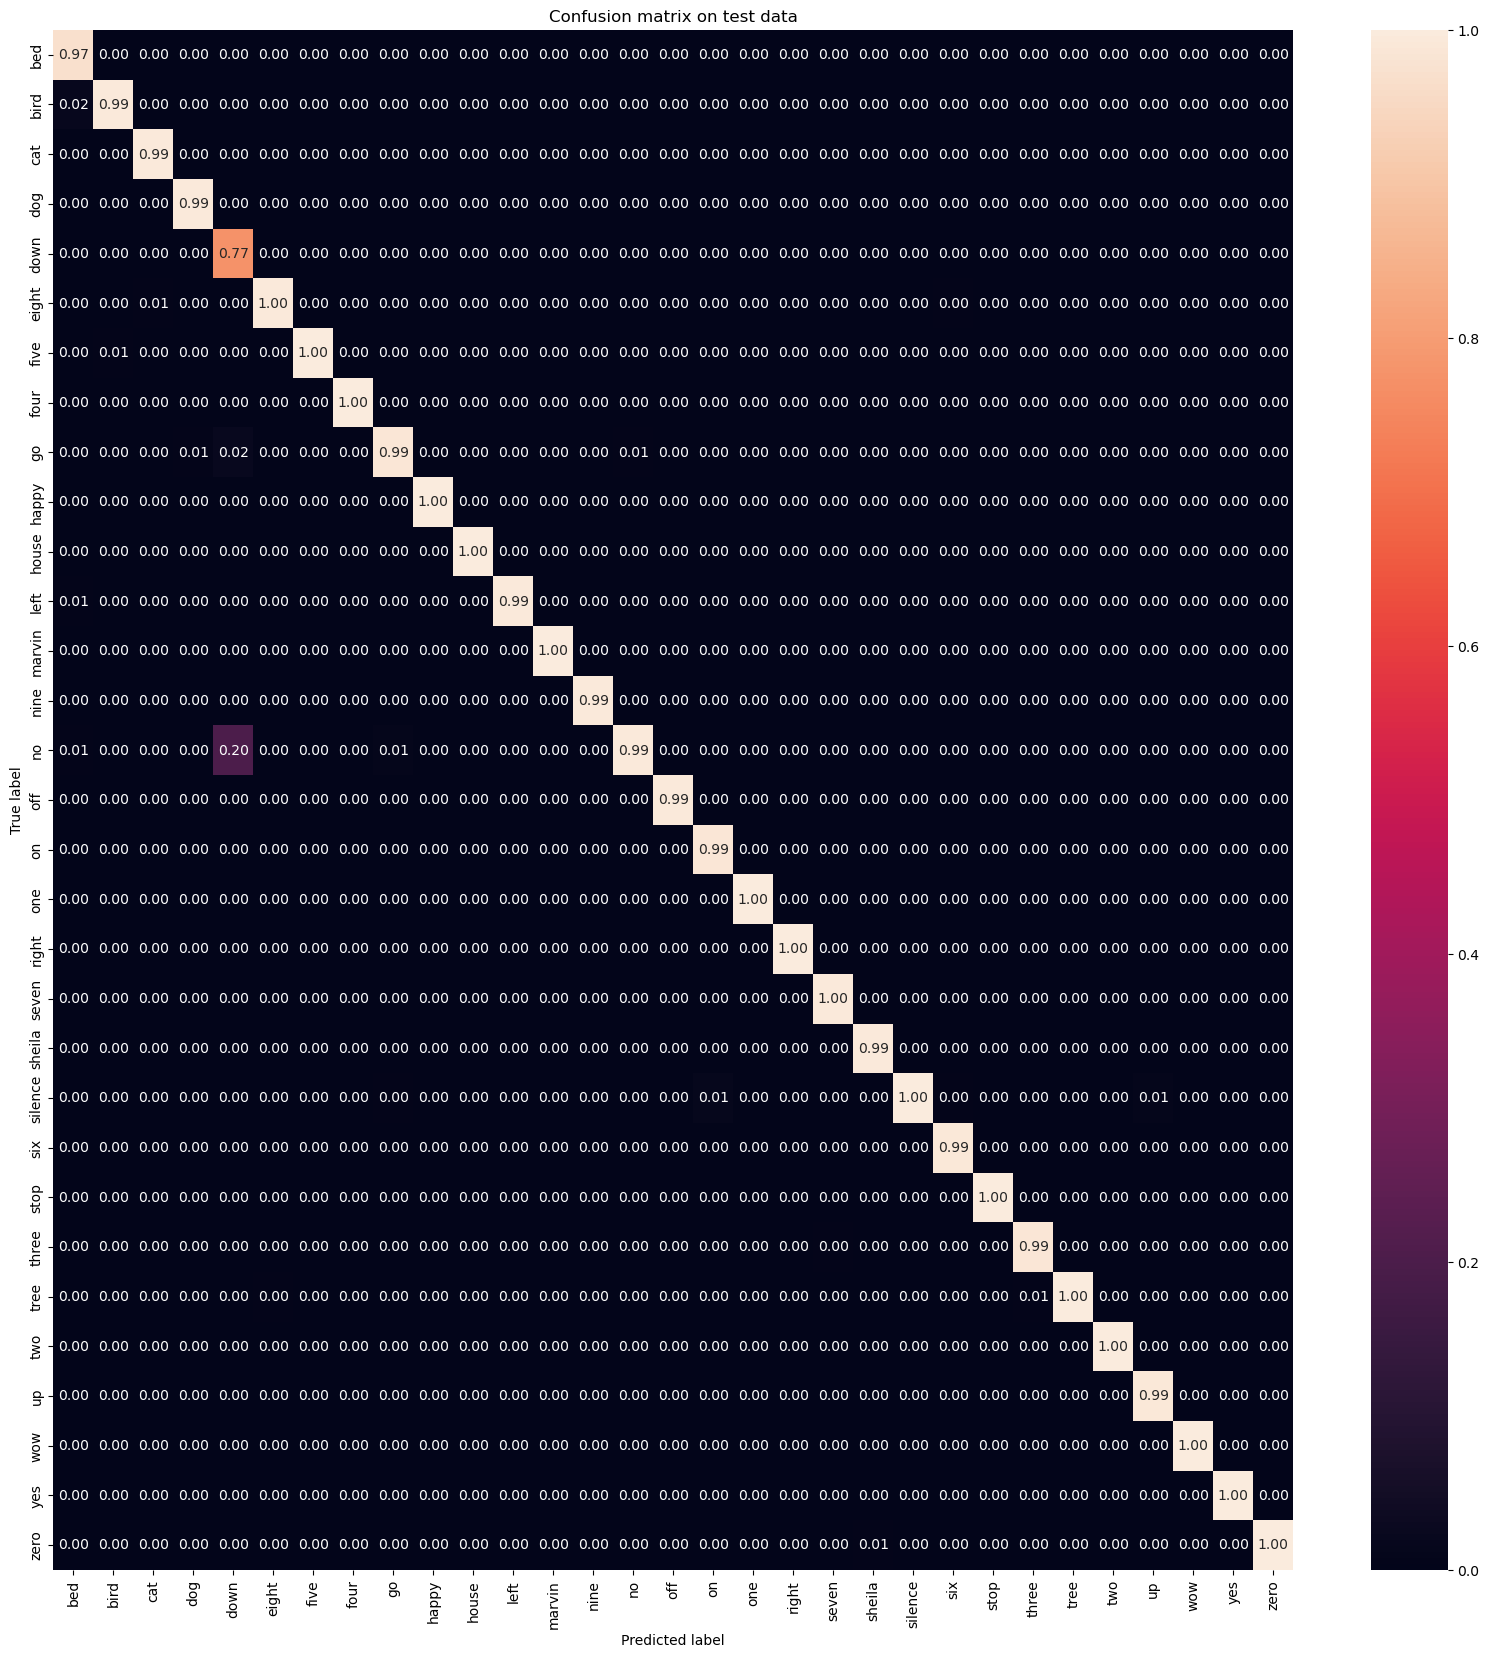

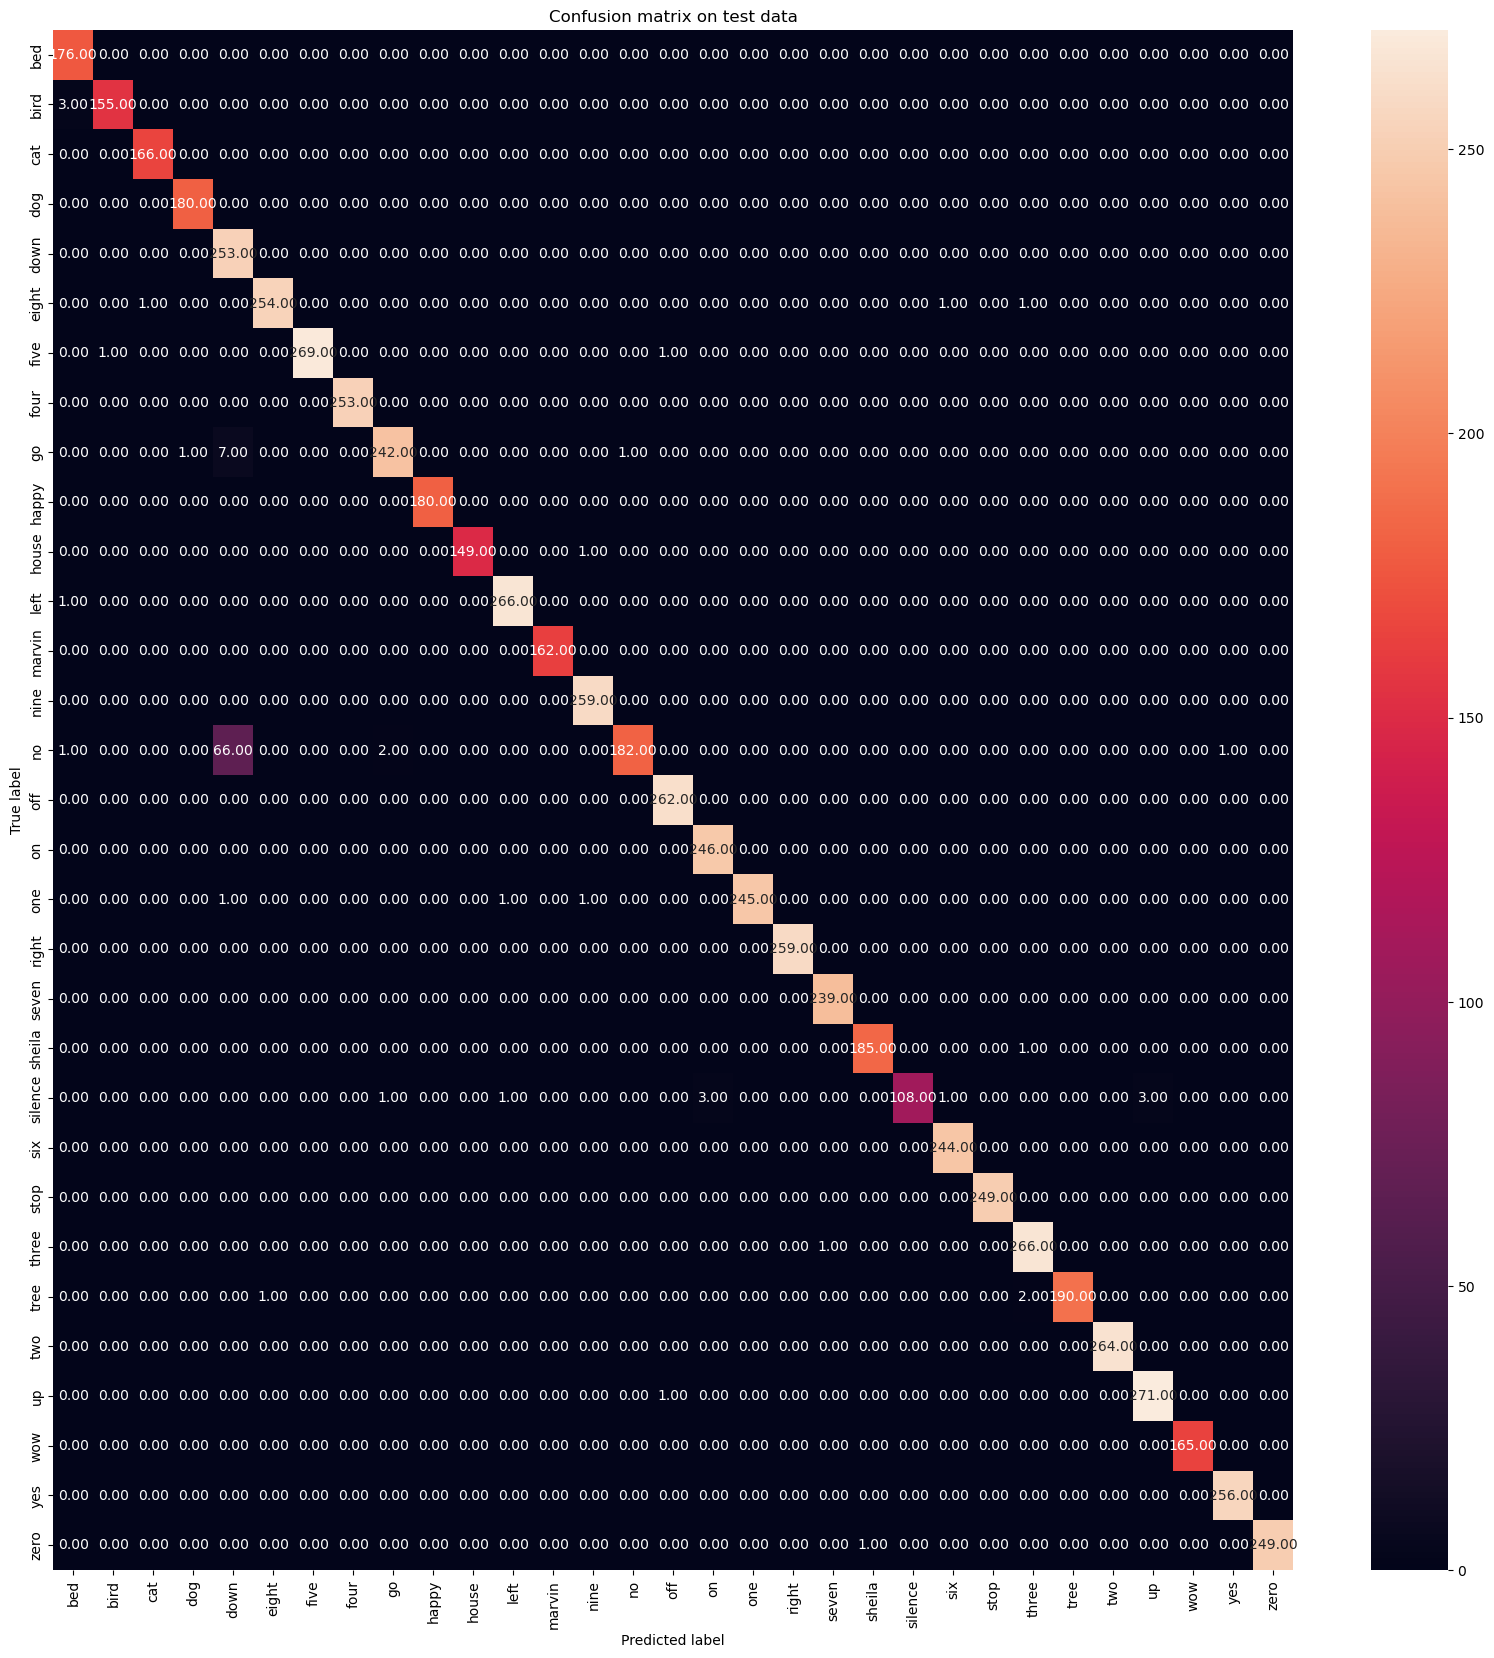

2031/2031 [==============================] - 84s 41ms/step
Accuracy score on train dataset: 0.9869340392132722
217/217 [==============================] - 9s 42ms/step
Accuracy score on validation dataset: 0.9839479392624729
Accuracy score on test dataset: 0.9844649021864211
Training with seed 40
Epoch 1/25
2031/2031 [==============================] - 249s 122ms/step - loss: 1.6723 - accuracy: 0.5062 - val_loss: 0.7077 - val_accuracy: 0.7936
Epoch 2/25
2031/2031 [==============================] - 232s 114ms/step - loss: 0.5441 - accuracy: 0.8417 - val_loss: 0.3995 - val_accuracy: 0.8823
Epoch 3/25
2031/2031 [==============================] - 229s 113ms/step - loss: 0.3592 - accuracy: 0.8975 - val_loss: 0.3154 - val_accuracy: 0.9125
Epoch 4/25
2031/2031 [==============================] - 225s 111ms/step - loss: 0.2749 - accuracy: 0.9219 - val_loss: 0.2273 - val_accuracy: 0.9404
Epoch 5/25
2031/2031 [==============================] - 225s 111ms/step - loss: 0.2270 - accuracy: 0.9353 - val

INFO:tensorflow:Assets written to: checkpoint_lstm_hidden_300\40\model_20240119-180825\assets


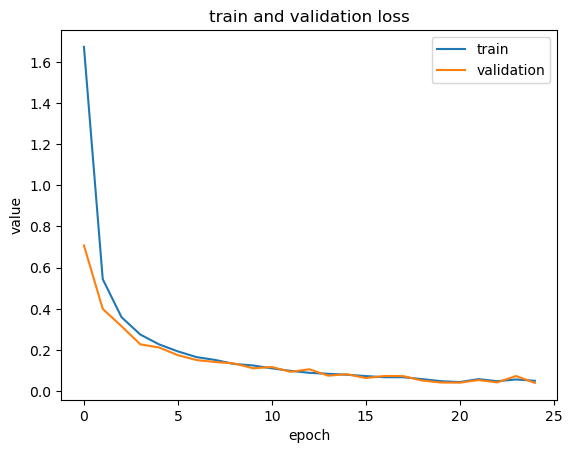

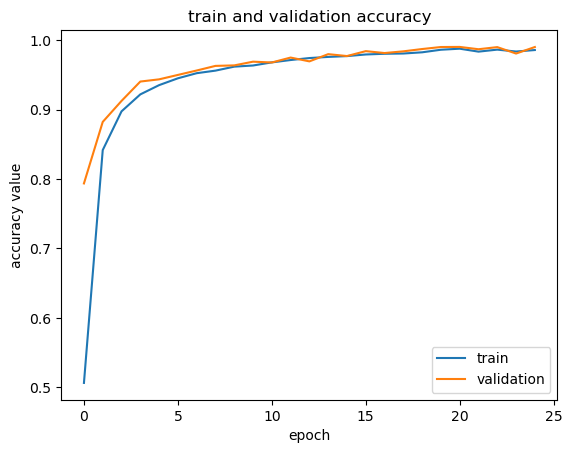

218/218 [==============================] - 9s 39ms/step


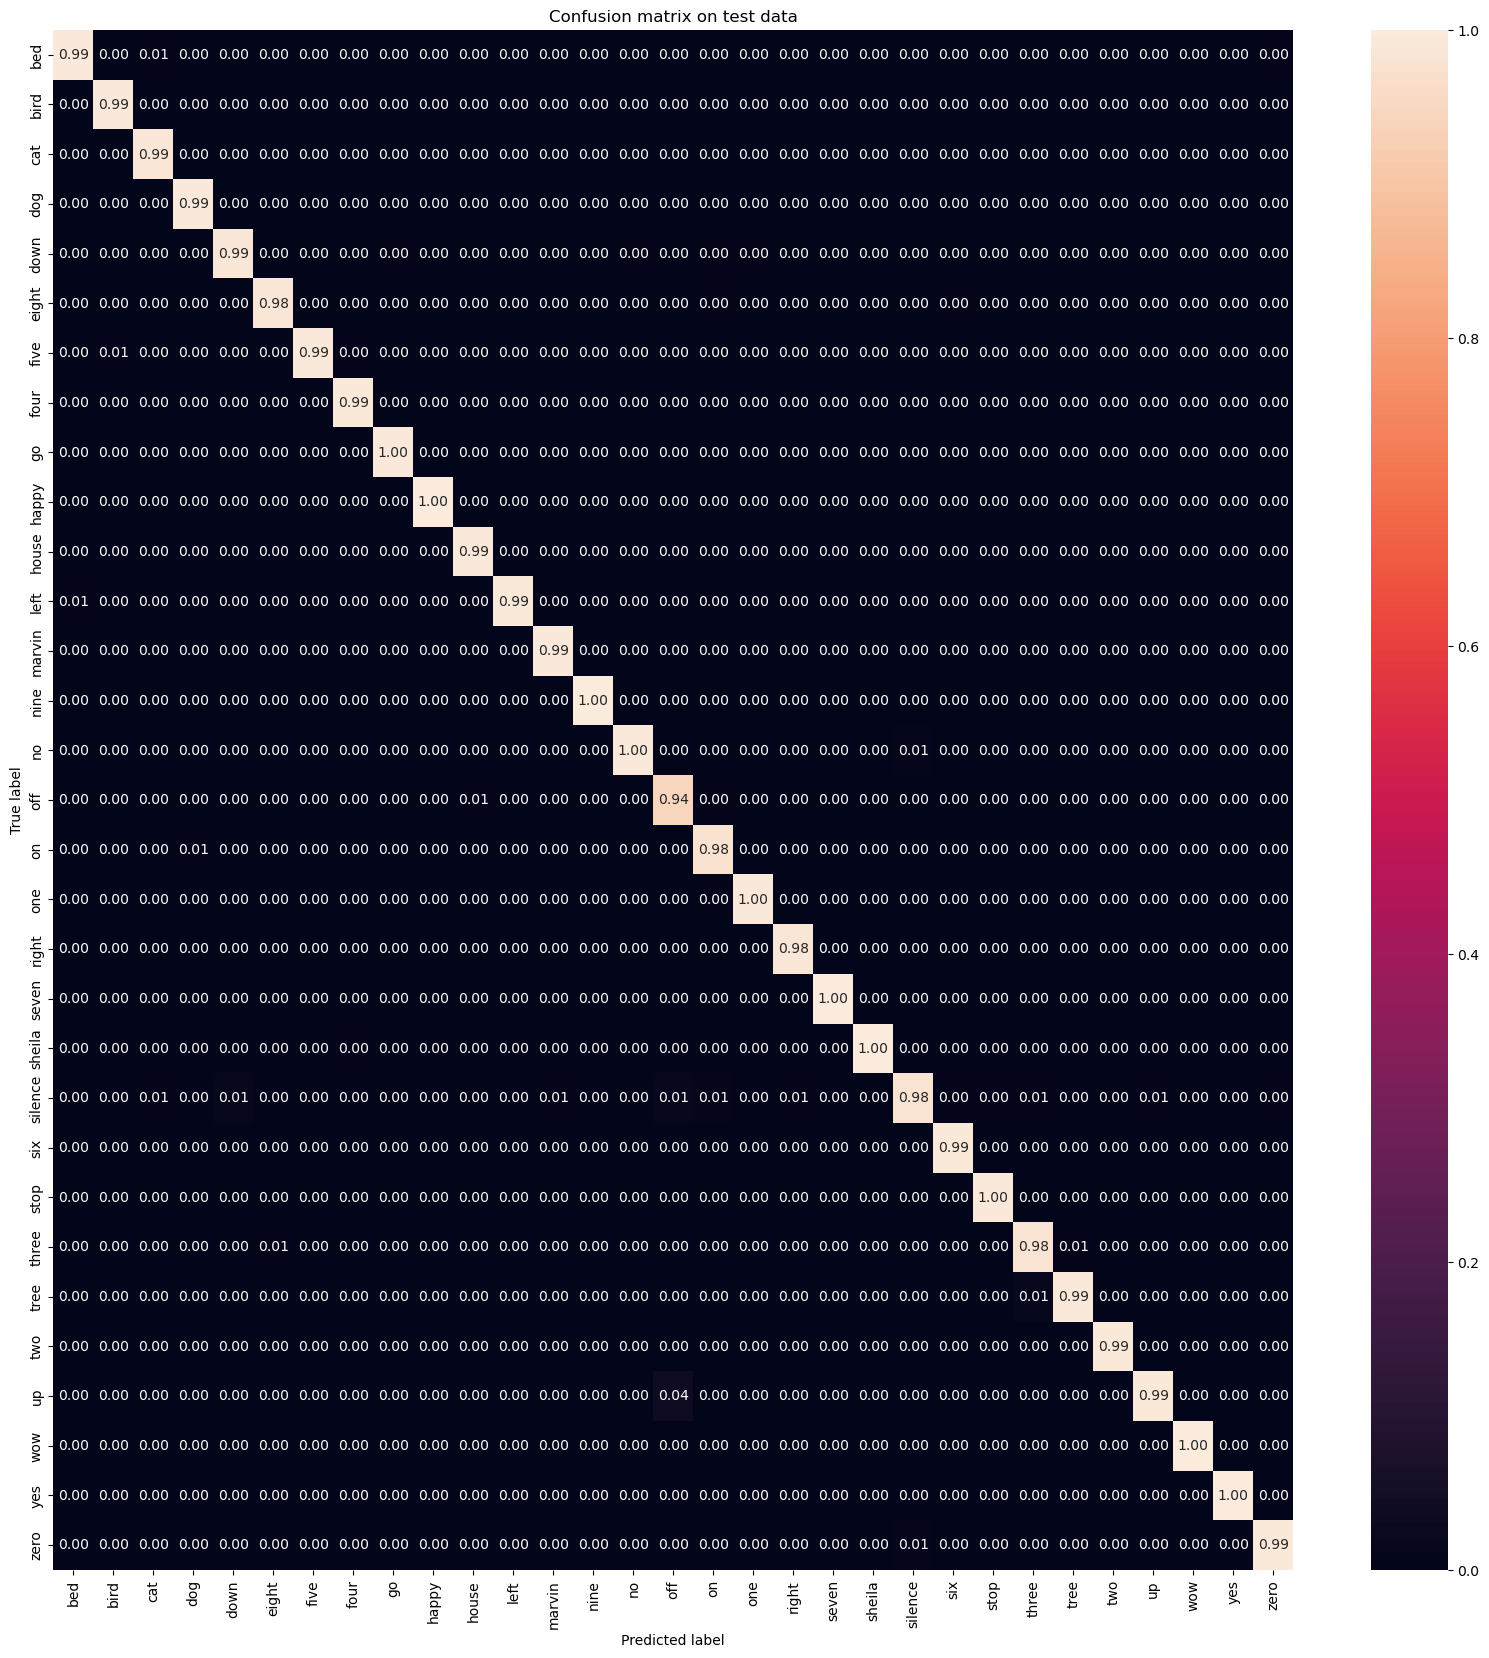

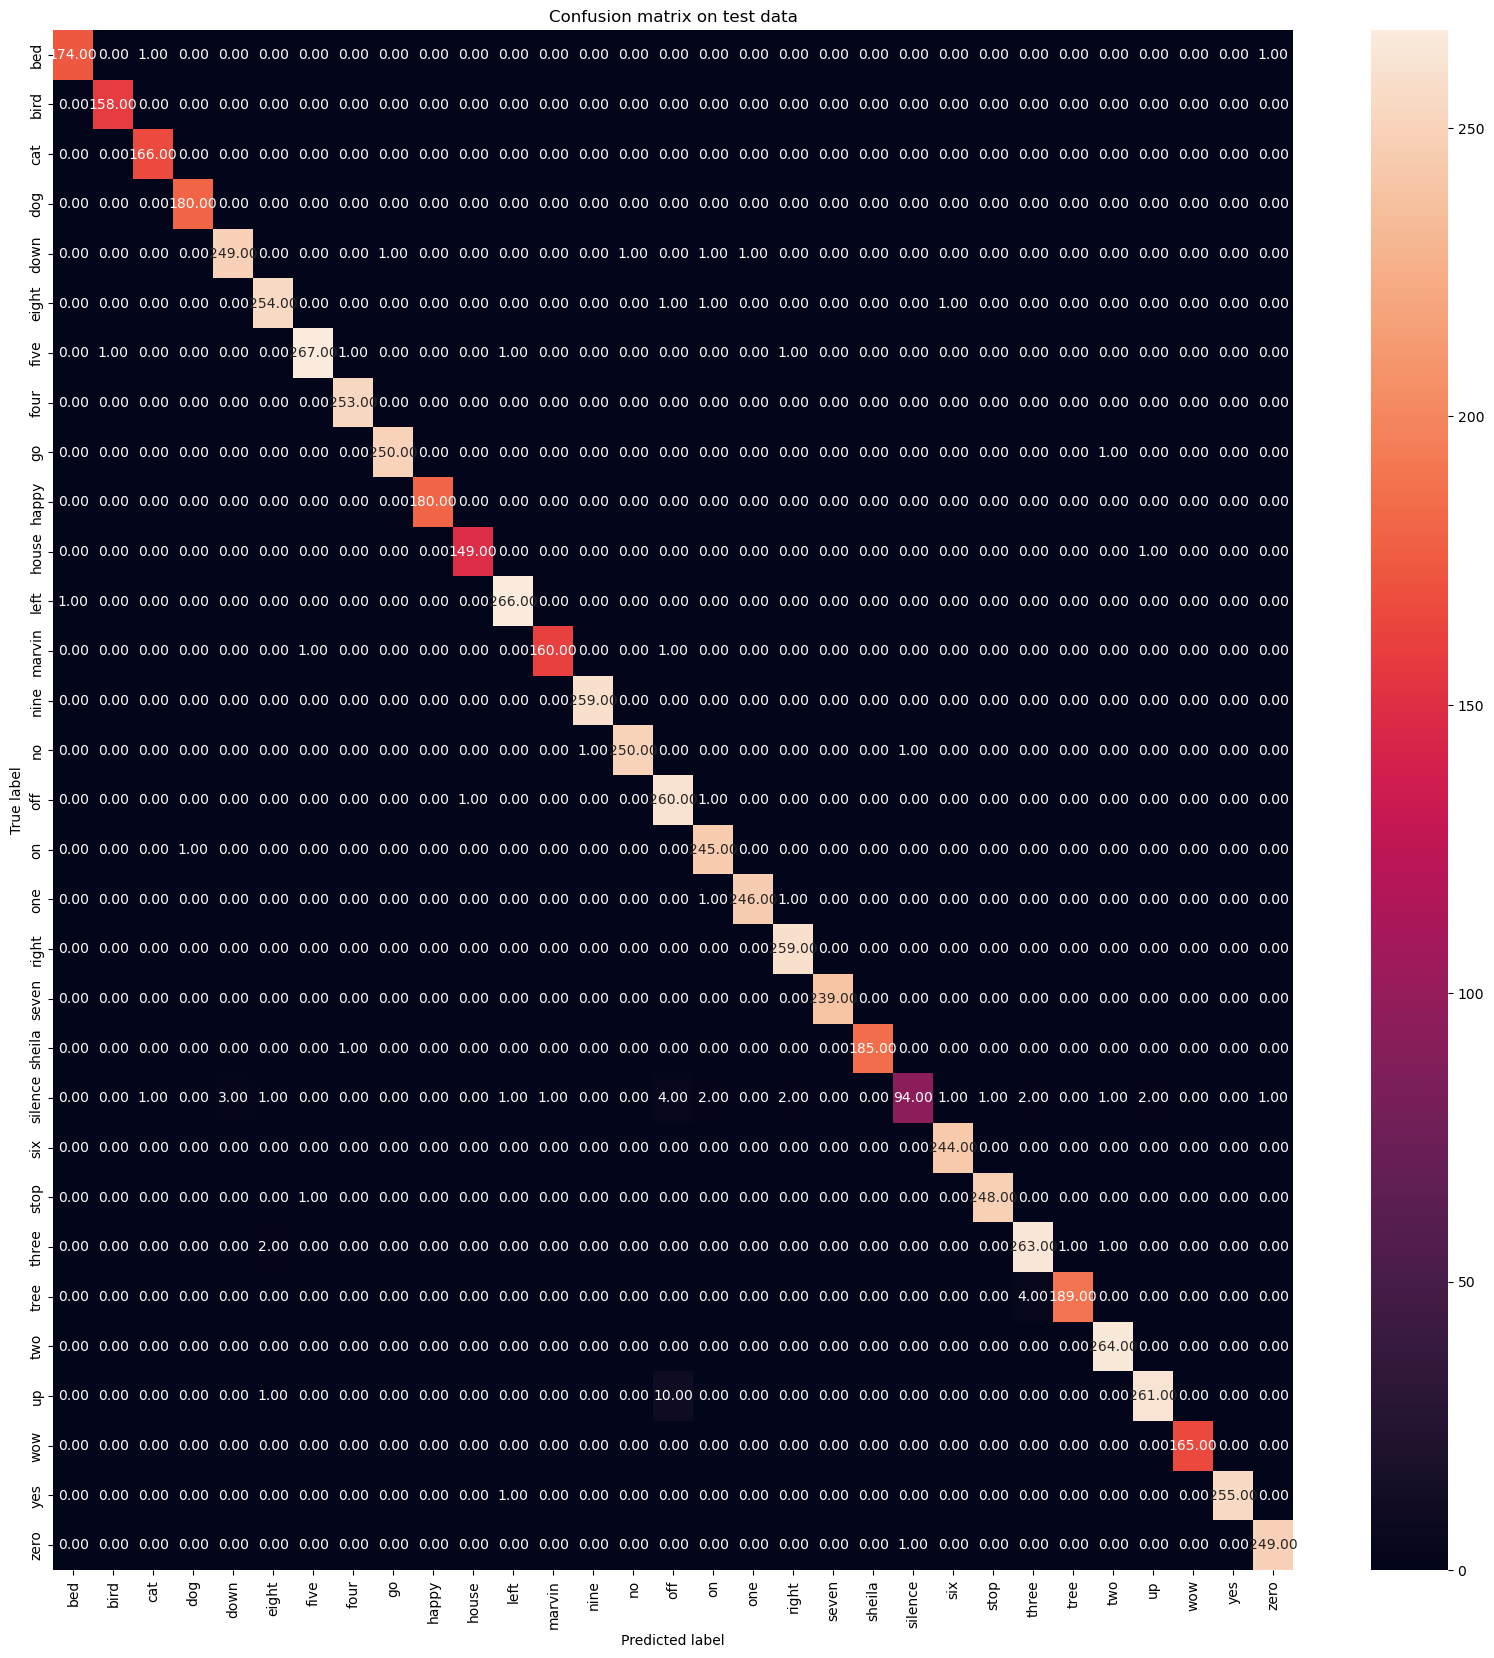

2031/2031 [==============================] - 77s 38ms/step
Accuracy score on train dataset: 0.9934747145187602
217/217 [==============================] - 9s 40ms/step
Accuracy score on validation dataset: 0.9901663051337671
Accuracy score on test dataset: 0.9897871116225546


In [22]:
def model2():
    model = Sequential()
    model.add(LSTM(300,input_shape=(99,13),return_sequences=True))
    model.add(LSTM(300,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

repeat_train(model2, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=25, batch=32,
             seeds=[0, 40], path='checkpoint_lstm_hidden_300')

Training with seed 0
Epoch 1/25
2031/2031 [==============================] - 365s 178ms/step - loss: 1.4761 - accuracy: 0.5612 - val_loss: 0.6452 - val_accuracy: 0.8088
Epoch 2/25
2031/2031 [==============================] - 328s 162ms/step - loss: 0.4938 - accuracy: 0.8558 - val_loss: 0.3579 - val_accuracy: 0.8972
Epoch 3/25
2031/2031 [==============================] - 328s 162ms/step - loss: 0.3308 - accuracy: 0.9037 - val_loss: 0.2647 - val_accuracy: 0.9248
Epoch 4/25
2031/2031 [==============================] - 329s 162ms/step - loss: 0.2712 - accuracy: 0.9214 - val_loss: 0.2266 - val_accuracy: 0.9343
Epoch 5/25
2031/2031 [==============================] - 329s 162ms/step - loss: 0.2188 - accuracy: 0.9374 - val_loss: 0.1931 - val_accuracy: 0.9453
Epoch 6/25
2031/2031 [==============================] - 330s 162ms/step - loss: 0.1835 - accuracy: 0.9465 - val_loss: 0.1688 - val_accuracy: 0.9523
Epoch 7/25
2031/2031 [==============================] - 329s 162ms/step - loss: 0.1552 - ac

INFO:tensorflow:Assets written to: checkpoint_lstm_bidirectional\0\model_20240119-202940\assets


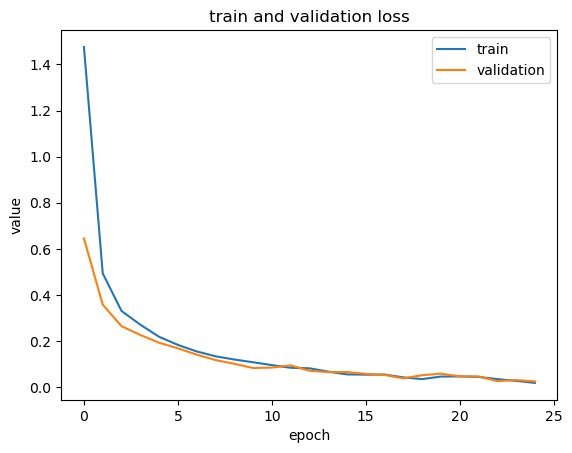

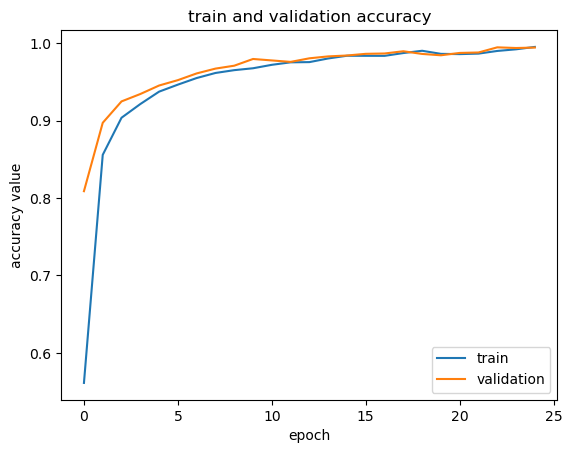

218/218 [==============================] - 8s 35ms/step


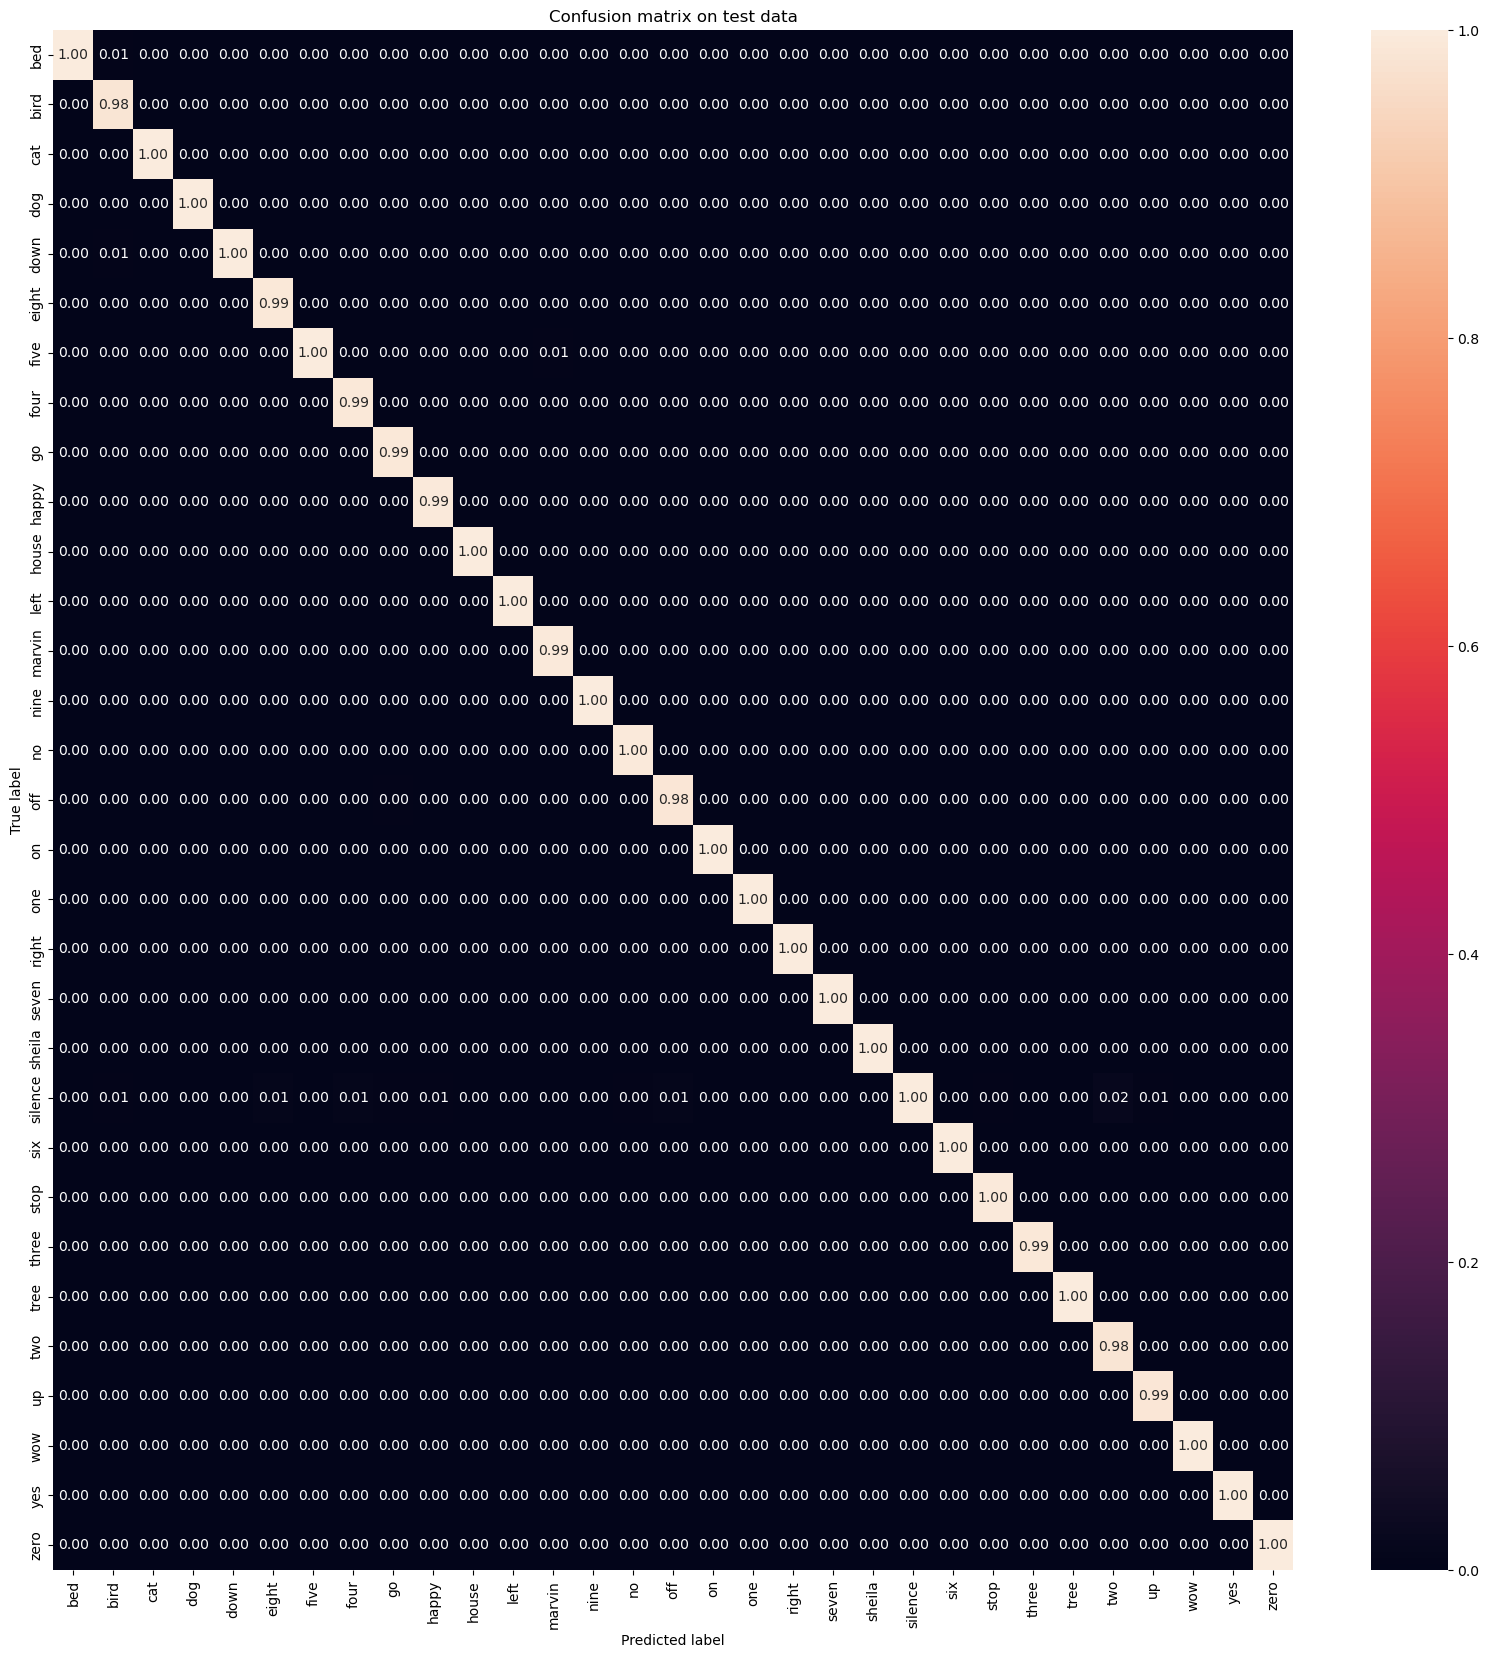

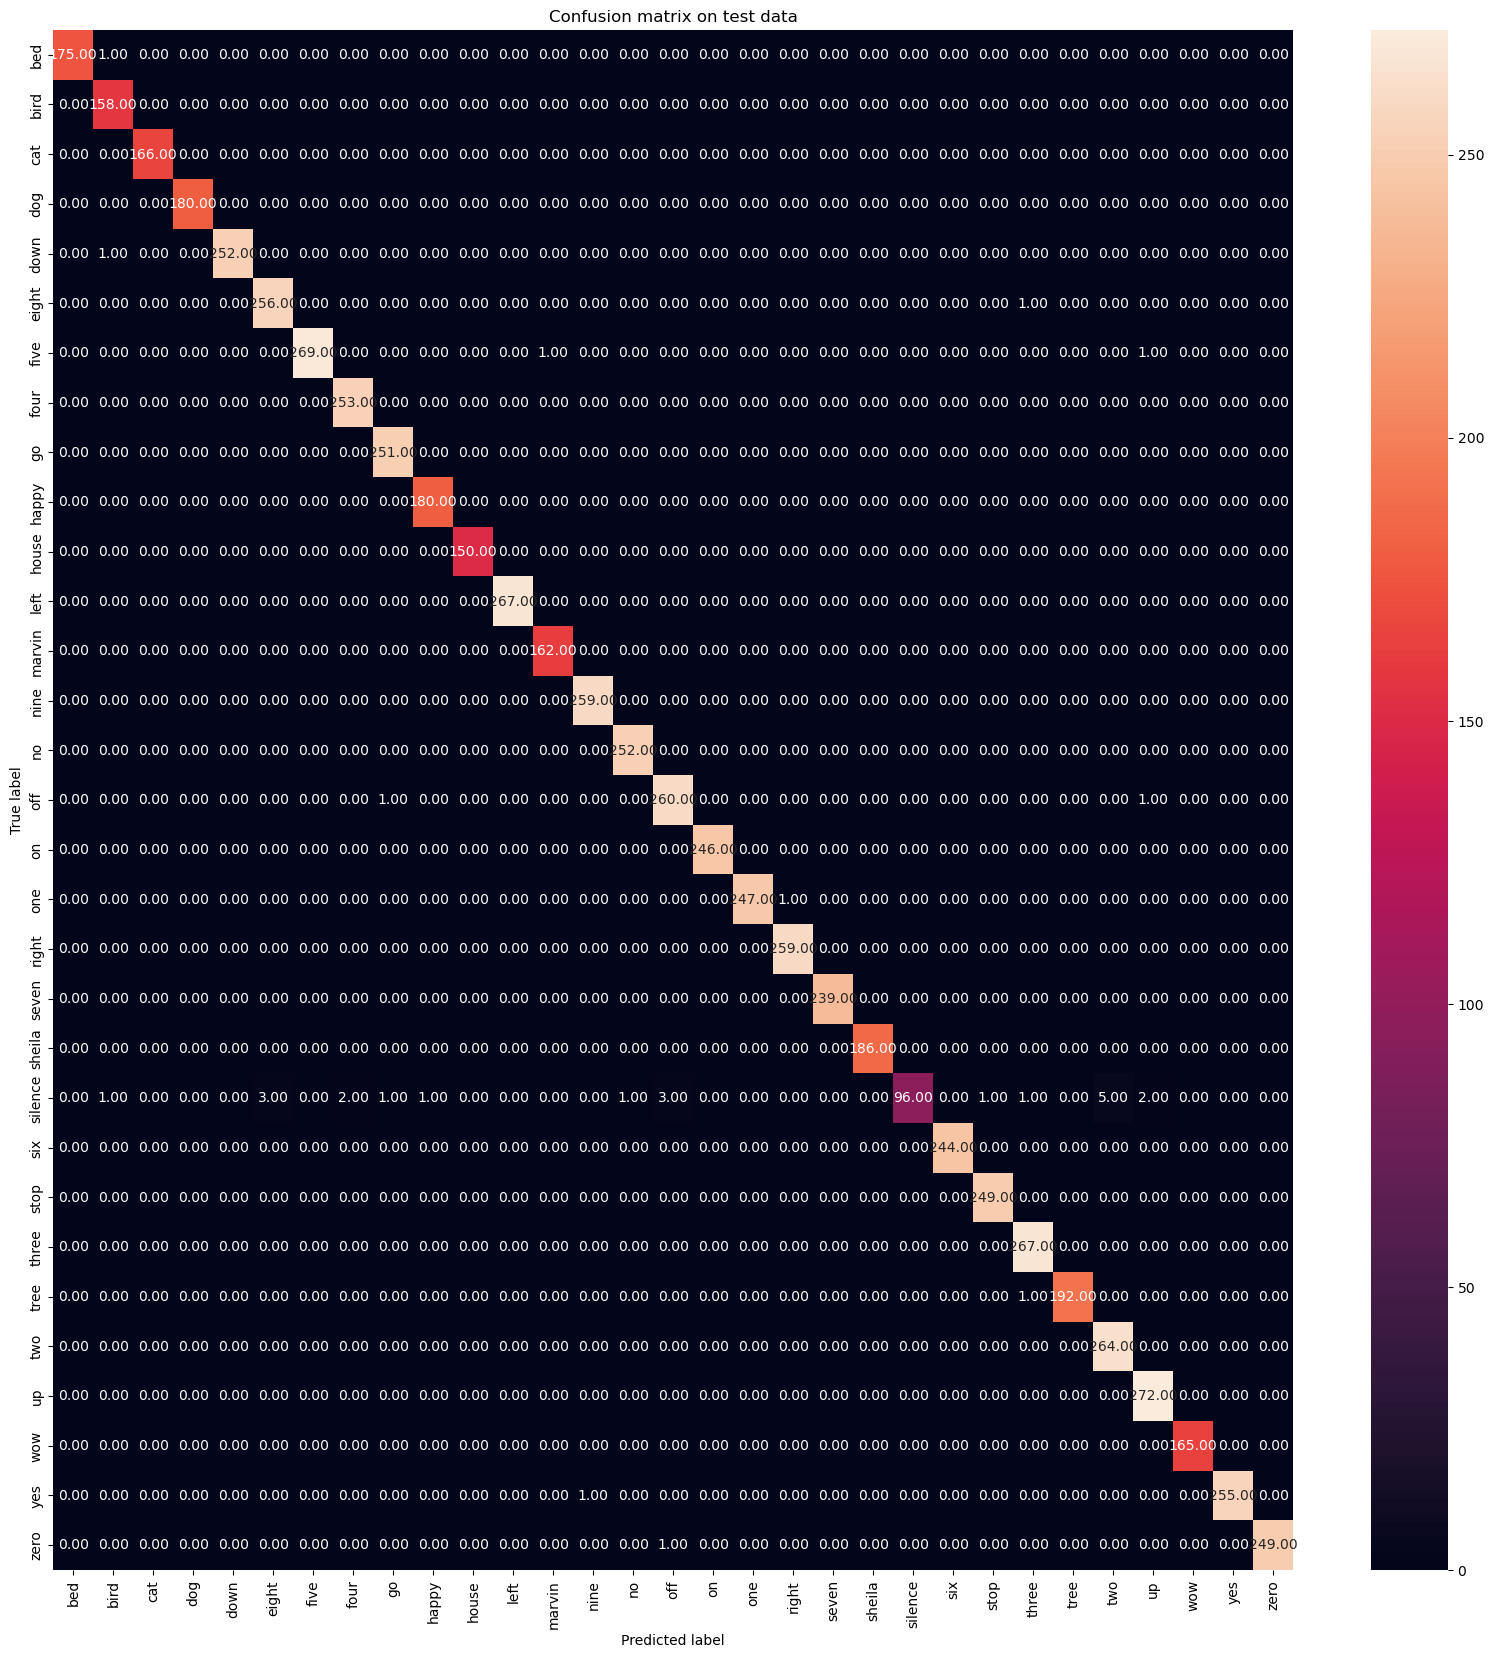

2031/2031 [==============================] - 84s 41ms/step
Accuracy score on train dataset: 0.9981378312659669
217/217 [==============================] - 9s 41ms/step
Accuracy score on validation dataset: 0.9943600867678959
Accuracy score on test dataset: 0.9953970080552359
Training with seed 40
Epoch 1/25
2031/2031 [==============================] - 431s 210ms/step - loss: 1.2959 - accuracy: 0.6174 - val_loss: 0.5184 - val_accuracy: 0.8458
Epoch 2/25
2031/2031 [==============================] - 432s 213ms/step - loss: 0.4450 - accuracy: 0.8703 - val_loss: 0.3323 - val_accuracy: 0.9073
Epoch 3/25
2031/2031 [==============================] - 429s 211ms/step - loss: 0.3147 - accuracy: 0.9095 - val_loss: 0.2483 - val_accuracy: 0.9313
Epoch 4/25
2031/2031 [==============================] - 430s 212ms/step - loss: 0.2464 - accuracy: 0.9293 - val_loss: 0.2277 - val_accuracy: 0.9401
Epoch 5/25
2031/2031 [==============================] - 422s 208ms/step - loss: 0.2020 - accuracy: 0.9421 - val

INFO:tensorflow:Assets written to: checkpoint_lstm_bidirectional\40\model_20240119-233424\assets


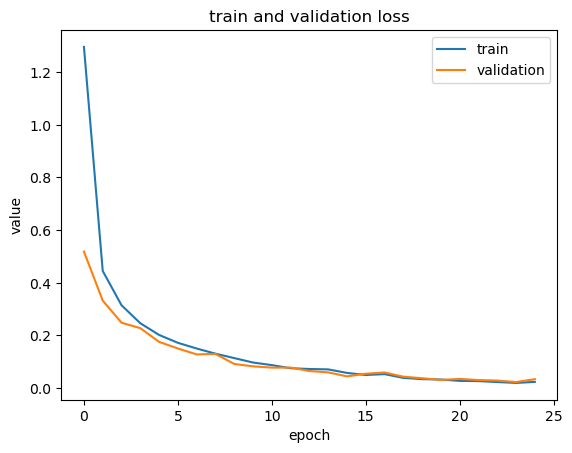

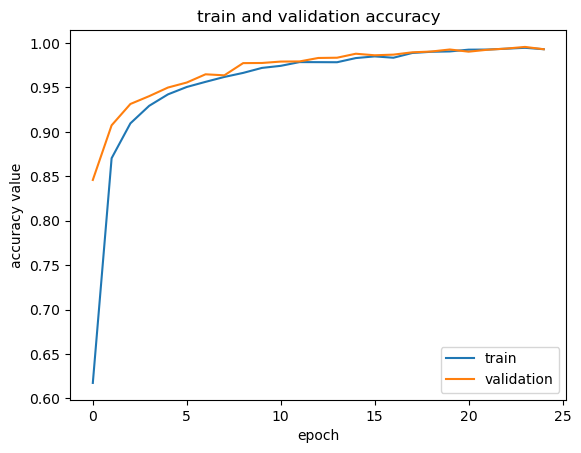

218/218 [==============================] - 10s 41ms/step


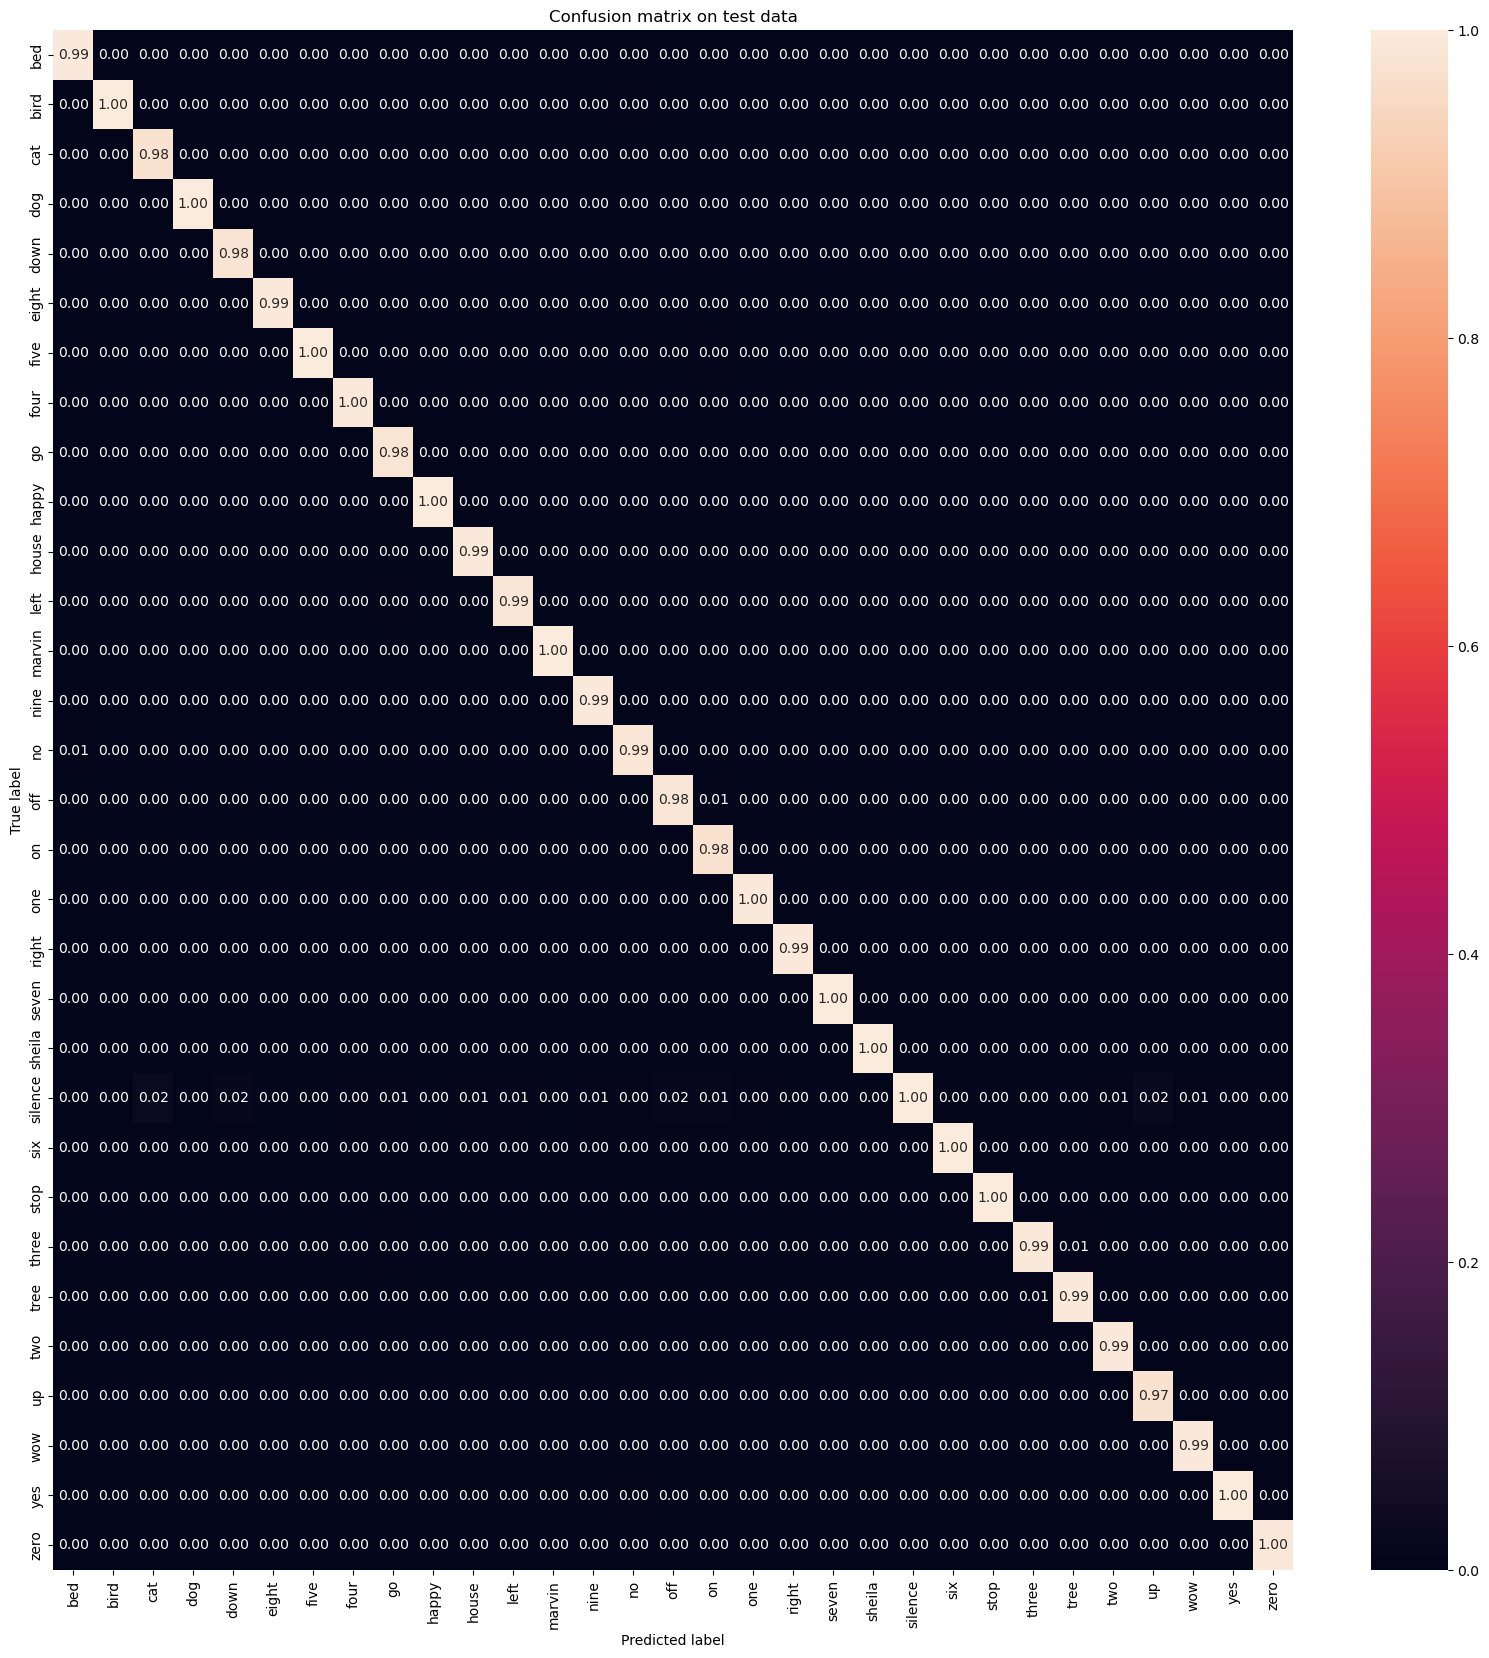

2031/2031 [==============================] - 100s 49ms/step
Accuracy score on train dataset: 0.9980301024962295
217/217 [==============================] - 11s 49ms/step
Accuracy score on validation dataset: 0.9929139551699204
Accuracy score on test dataset: 0.991800920598389


In [23]:
def model3():
    model = Sequential()
    model.add(Bidirectional(LSTM(200, input_shape=(99,13), return_sequences=True)))
    model.add(Bidirectional(LSTM(200, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

repeat_train(model3, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=25, batch=32,
             seeds=[0, 40], path='checkpoint_lstm_bidirectional')

Training with seed 0
Epoch 1/25
2031/2031 [==============================] - 217s 106ms/step - loss: 1.1301 - accuracy: 0.6695 - val_loss: 0.4559 - val_accuracy: 0.8707
Epoch 2/25
2031/2031 [==============================] - 217s 107ms/step - loss: 0.3823 - accuracy: 0.8899 - val_loss: 0.2849 - val_accuracy: 0.9166
Epoch 3/25
2031/2031 [==============================] - 212s 105ms/step - loss: 0.2764 - accuracy: 0.9219 - val_loss: 0.2300 - val_accuracy: 0.9359
Epoch 4/25
2031/2031 [==============================] - 213s 105ms/step - loss: 0.2203 - accuracy: 0.9383 - val_loss: 0.1880 - val_accuracy: 0.9488
Epoch 5/25
2031/2031 [==============================] - 215s 106ms/step - loss: 0.1832 - accuracy: 0.9478 - val_loss: 0.1738 - val_accuracy: 0.9501
Epoch 6/25
2031/2031 [==============================] - 213s 105ms/step - loss: 0.1554 - accuracy: 0.9551 - val_loss: 0.1309 - val_accuracy: 0.9654
Epoch 7/25
2031/2031 [==============================] - 211s 104ms/step - loss: 0.1343 - ac

INFO:tensorflow:Assets written to: checkpoint_GRU_two_layer\0\model_20240120-005109\assets


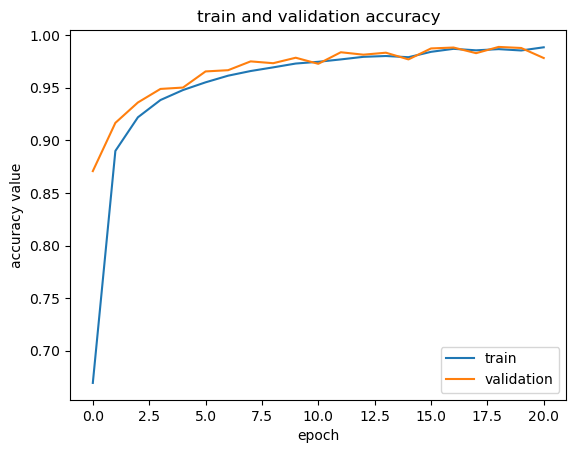

218/218 [==============================] - 6s 27ms/step


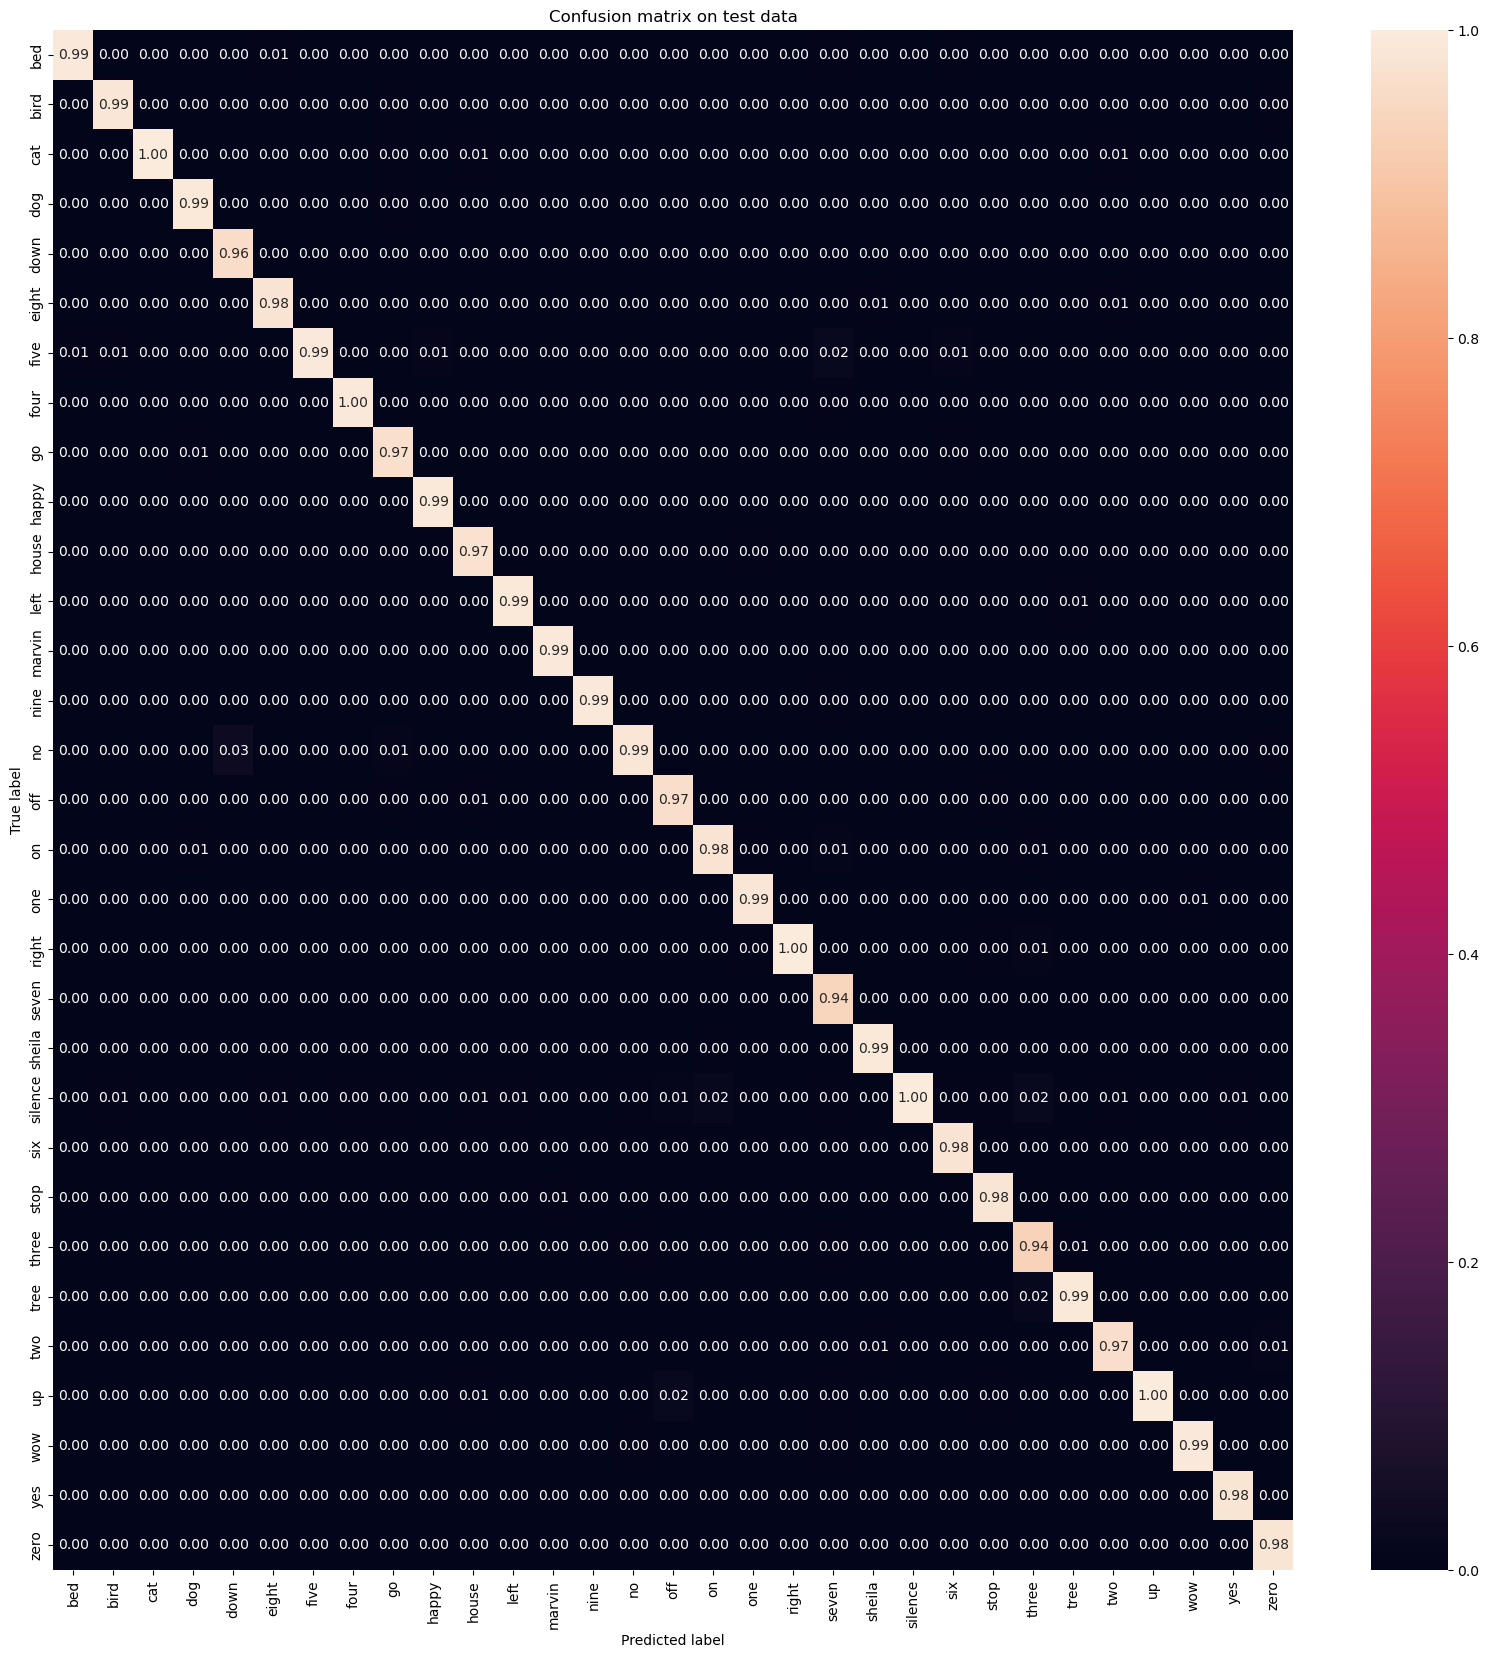

2031/2031 [==============================] - 55s 27ms/step
Accuracy score on train dataset: 0.9839638031333682
217/217 [==============================] - 6s 27ms/step
Accuracy score on validation dataset: 0.9781634128705712
Accuracy score on test dataset: 0.9817318757192175
Training with seed 40
Epoch 1/25
2031/2031 [==============================] - 217s 106ms/step - loss: 1.1082 - accuracy: 0.6775 - val_loss: 0.4542 - val_accuracy: 0.8668
Epoch 2/25
2031/2031 [==============================] - 216s 107ms/step - loss: 0.3698 - accuracy: 0.8945 - val_loss: 0.2791 - val_accuracy: 0.9226
Epoch 3/25
2031/2031 [==============================] - 216s 107ms/step - loss: 0.2751 - accuracy: 0.9214 - val_loss: 0.2244 - val_accuracy: 0.9383
Epoch 4/25
2031/2031 [==============================] - 214s 105ms/step - loss: 0.2179 - accuracy: 0.9379 - val_loss: 0.1797 - val_accuracy: 0.9487
Epoch 5/25
2031/2031 [==============================] - 214s 105ms/step - loss: 0.1799 - accuracy: 0.9489 - val

INFO:tensorflow:Assets written to: checkpoint_GRU_two_layer\40\model_20240120-021122\assets


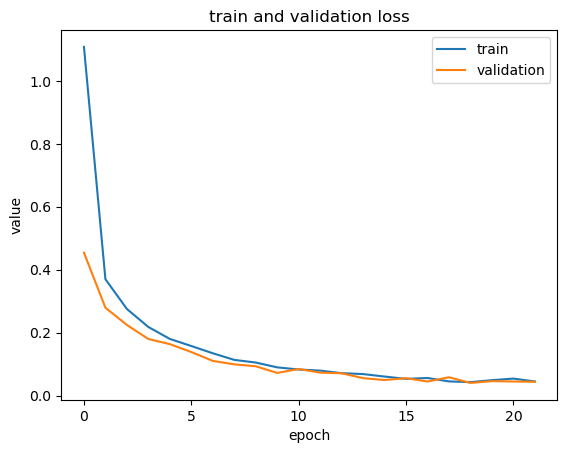

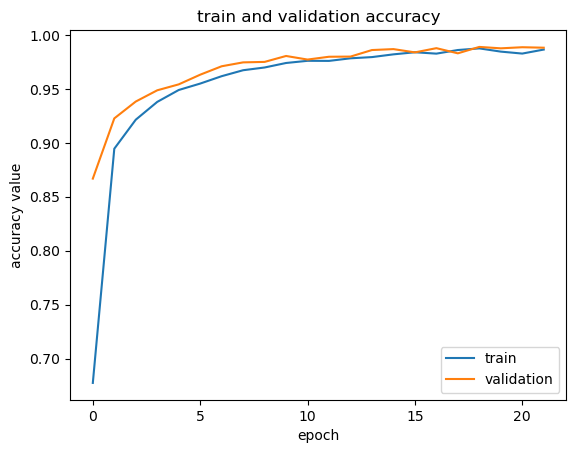

218/218 [==============================] - 7s 29ms/step


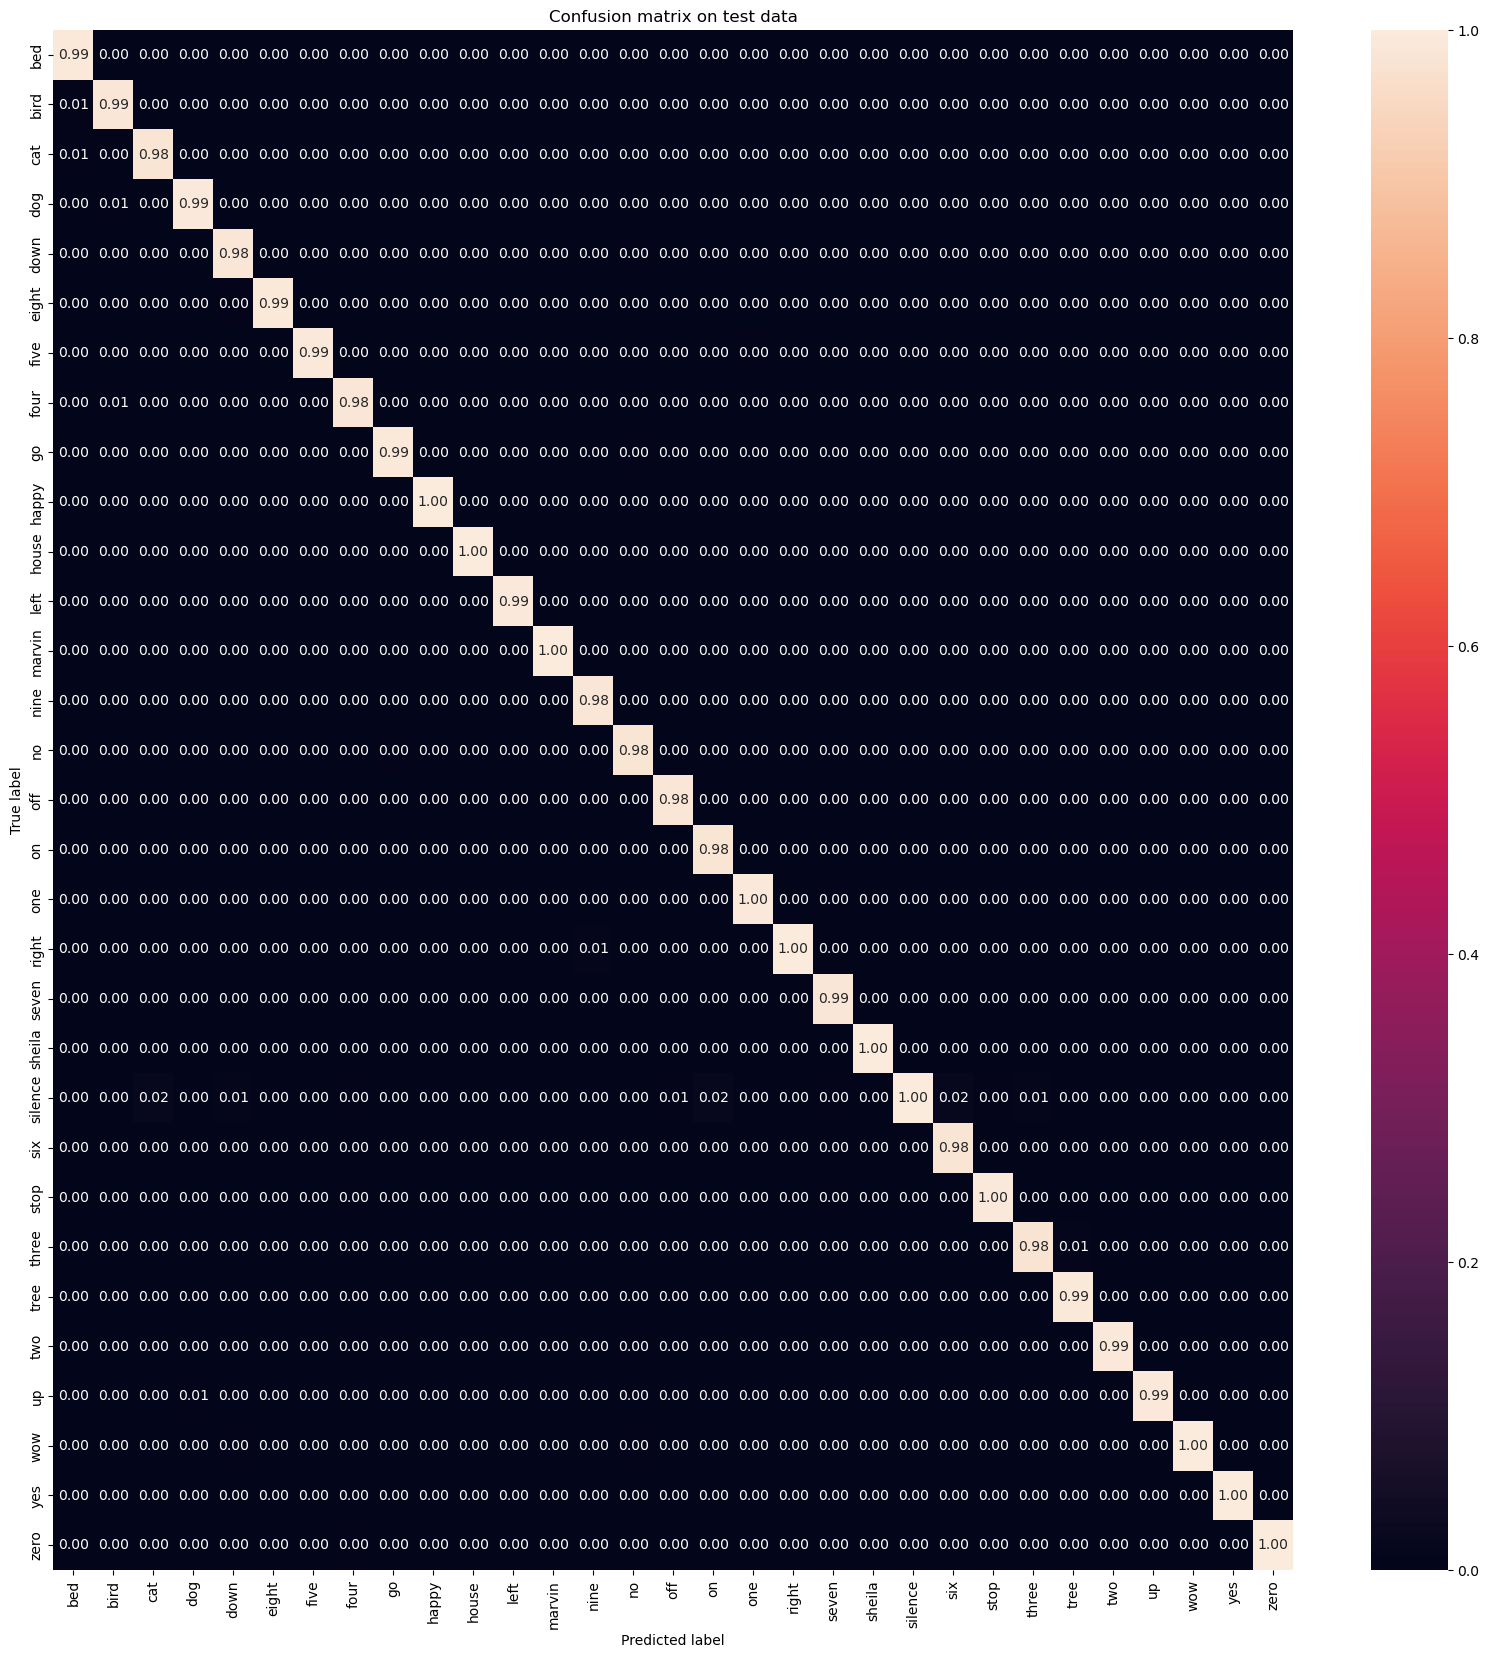

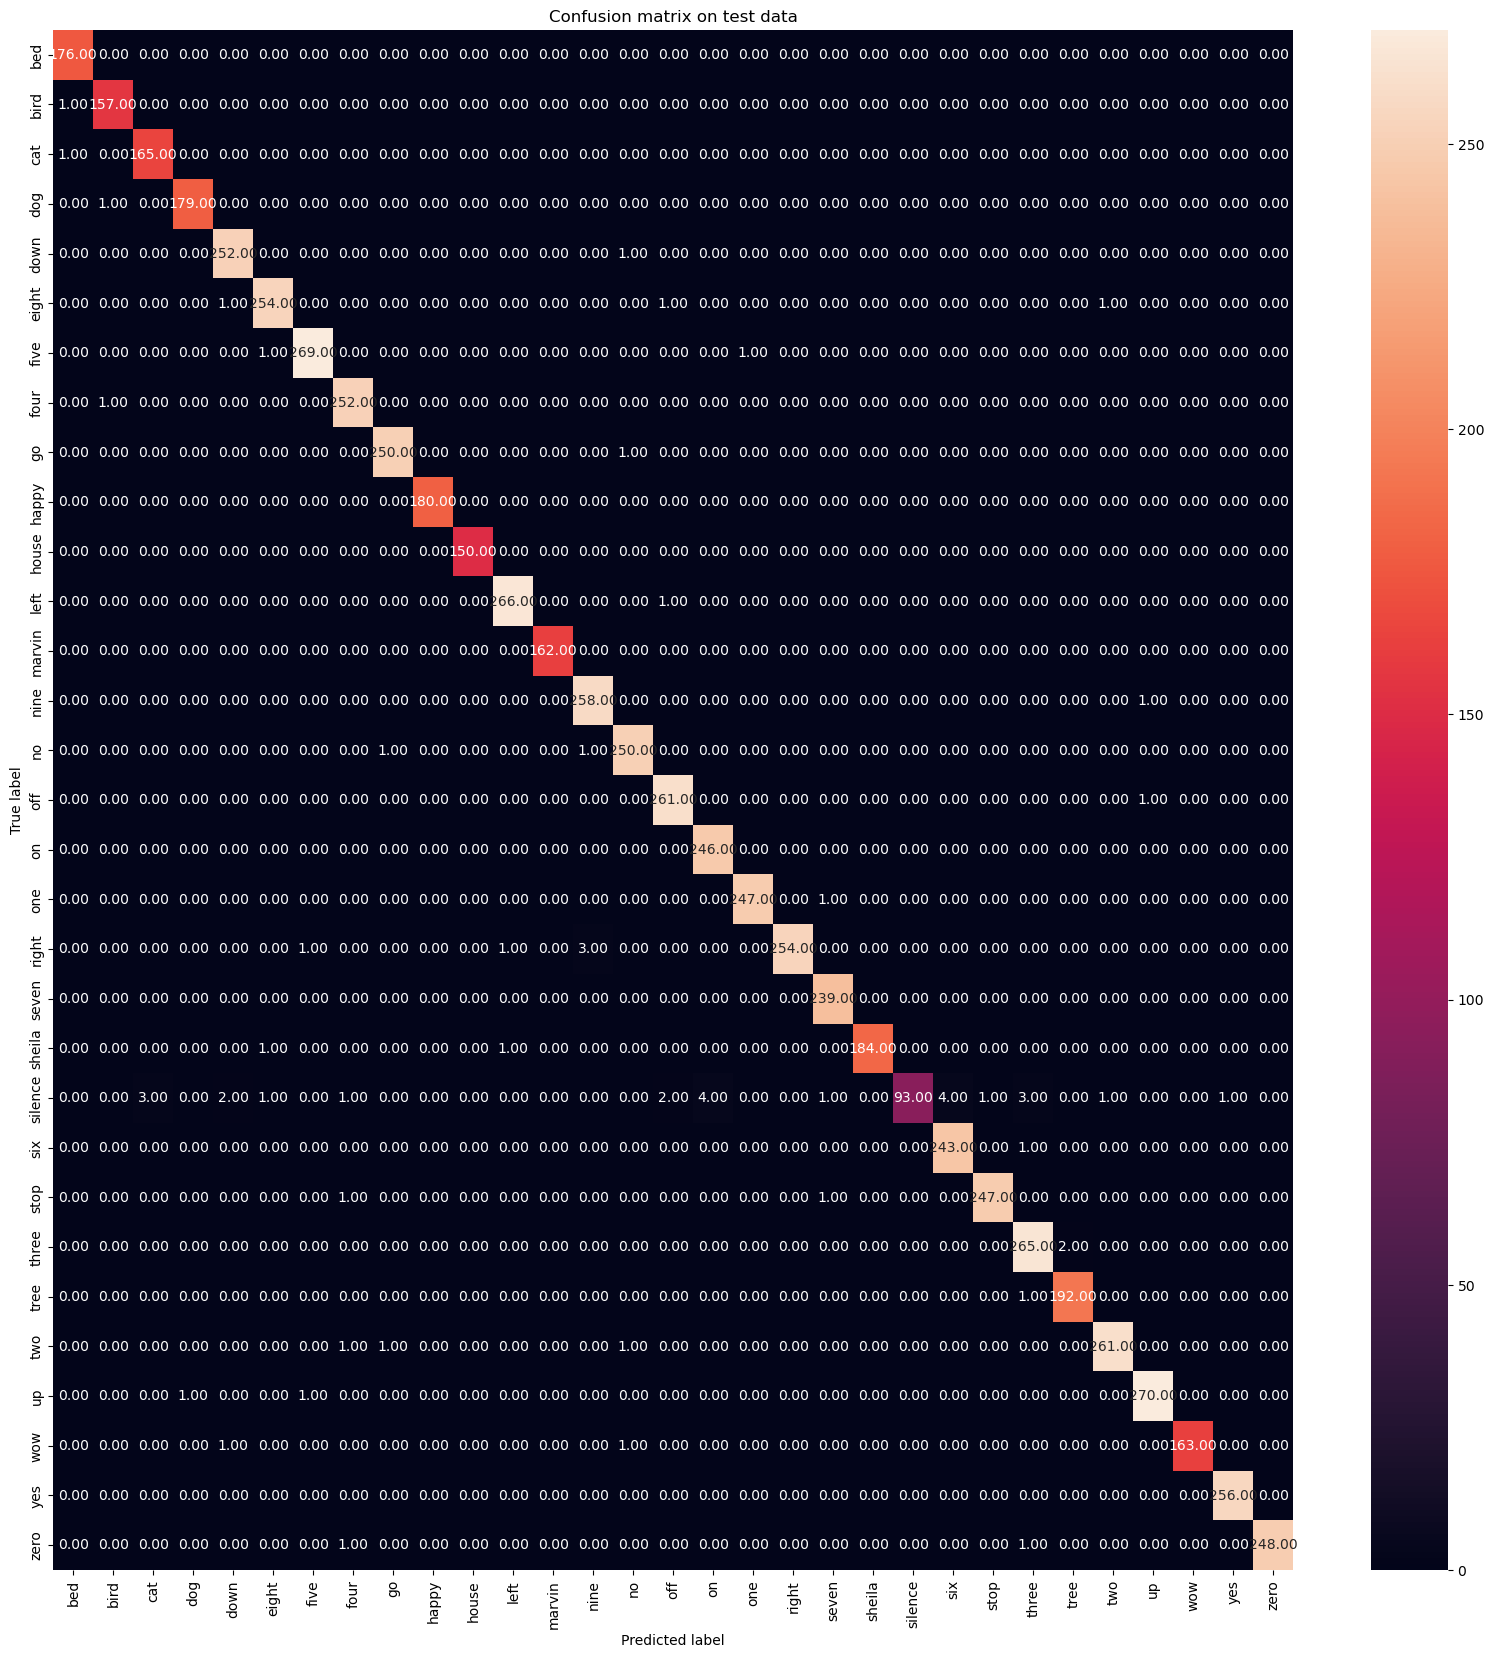

2031/2031 [==============================] - 56s 28ms/step
Accuracy score on train dataset: 0.9938748499492136
217/217 [==============================] - 6s 28ms/step
Accuracy score on validation dataset: 0.9881417208966016
Accuracy score on test dataset: 0.9909378596087457


In [24]:
def model4():
    model = Sequential()
    model.add(GRU(200,input_shape=(99,13),return_sequences=True))
    model.add(GRU(200,return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    return model

repeat_train(model4, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=25, batch=32,
             seeds=[0, 40], path='checkpoint_GRU_two_layer')